# Hull Tactical – Market Prediction
Contexto: competição Hull Tactical no Kaggle. Objetivo: explorar dados e montar baseline rápido para retornos/allocations. Métrica foco: Sharpe ajustado oficial (sempre); RMSE apenas como diagnóstico secundário.

**Resumo rápido (métrica e alvo)**
- Alvo: `market_forward_excess_returns` (retorno de mercado em excesso); se ausente, gera a partir de `forward_returns - risk_free_rate`.
- Métrica oficial: Sharpe ajustado da competição, aplicado **só onde `is_scored == 1`**, com penalização de volatilidade e retorno vs. mercado.
- Allocation enviada ao host: `position = clip(1 + k * y_hat, 0, 2)`, que representa a fração de capital no mercado (0 = caixa, 1 = 100% comprado, 2 = alavancado em 2x); é essa série que o host usa para calcular o desempenho.

**Mini-exemplo numérico (3 dias)**
Retornos do mercado = [1.0%, -0.5%, 0.2%], `risk_free_rate = 0`, allocation constante = 1.0.
-> Retorno da estratégia = mercado (mesmos 3 valores).
-> `adjusted_sharpe_score` ≈ 5.99 para essa sequência, igual ao script oficial de avaliação (após anualização e penalidades).

## 0. Instalação (opcional)
Execute esta célula uma vez se faltar alguma lib.

In [30]:
!pip install -q lightgbm xgboost optuna kaggle seaborn matplotlib pandas numpy scikit-learn

In [31]:
# Imports e setup geral
import os
import json
import pathlib
import random
import zipfile

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNet, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

try:  # display helper for non-notebook runs
    from IPython.display import display  # type: ignore
except Exception:  # pragma: no cover
    def display(obj):
        print(obj)

try:
    import xgboost as xgb

    HAS_XGB = True
except Exception:  # pragma: no cover
    HAS_XGB = False
try:
    from catboost import CatBoostRegressor

    HAS_CAT = True
except Exception:  # pragma: no cover
    HAS_CAT = False

SEED = 42
ALLOC_K = 1.0  # fator para mapear retorno previsto -> alocação (1 + k*y_hat, clip 0-2)
MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0

INTENTIONAL_DEFAULTS = {
    "clip_bounds": (-0.05, 0.05),  # clipping determinístico do excesso defasado
    "tanh_scale": 1.0,  # escala aplicada antes do tanh
    "zscore_window": 20,  # janela de std para o z-score defasado
    "zscore_clip": 5.0,  # limite para truncar o z-score
}
INTENTIONAL_CFG = dict(INTENTIONAL_DEFAULTS)

FEATURE_CFG_DEFAULT = {
    "winsor_quantile": 0.995,  # clipping bilateral para features muito skewed
    "skew_threshold": 3.0,  # aplica winsor se |skew| >= threshold
    "add_family_medians": True,
    "add_ratios": True,  # mean/std e mean-median por família
    "add_diffs": True,  # mean-std por família
    "use_extended_set": True,  # expõe o set E_fe_oriented
}
random.seed(SEED)
np.random.seed(SEED)

sns.set_theme()
pd.set_option("display.max_columns", 120)

# Hiperparâmetros de referência (melhores do Optuna)
BEST_PARAMS = {
    "learning_rate": 0.010897827897948612,
    "num_leaves": 42,
    "min_data_in_leaf": 388,
    "feature_fraction": 0.7079417306723327,
    "bagging_fraction": 0.6681010468585586,
    "bagging_freq": 10,
    "lambda_l1": 0.9244442250838115,
    "lambda_l2": 0.16637075433315218,
    "objective": "regression",
    "metric": "rmse",
    "seed": SEED,
    "verbosity": -1,
}

## 1. Credenciais do Kaggle (rodar primeiro)

In [32]:
# Setup rápido de credenciais
KAGGLE_USERNAME = ""  # seu user Kaggle
KAGGLE_KEY = ""       # sua key Kaggle

if KAGGLE_USERNAME and KAGGLE_KEY:
    creds = {"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}
    os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
    os.environ["KAGGLE_KEY"] = KAGGLE_KEY
    kaggle_dir = pathlib.Path("~/.kaggle").expanduser()
    kaggle_dir.mkdir(exist_ok=True)
    dest = kaggle_dir / "kaggle.json"
    dest.write_text(json.dumps(creds))
    dest.chmod(0o600)
    os.environ["KAGGLE_JSON"] = str(dest)
    os.environ["CUSTOM_KAGGLE_JSON"] = str(dest)
    print("kaggle.json criado em", dest)
else:
    print("Preencha KAGGLE_USERNAME e KAGGLE_KEY e rode.")

kaggle.json criado em /root/.kaggle/kaggle.json


## 2. Configuração do Kaggle CLI

In [33]:
# Configuração do kaggle.json e CLI
import shutil
import sys
import subprocess
from pathlib import Path

CUSTOM_KAGGLE_JSON = ""  # ex.: "/content/kaggle.json" no runtime
KAGGLE_USERNAME_MANUAL = ""  # alternativa: preencha user
KAGGLE_KEY_MANUAL = ""       # alternativa: preencha key

def running_in_colab():
    return "google.colab" in sys.modules


def find_kaggle_json(max_depth=5):
    candidates = []
    if CUSTOM_KAGGLE_JSON:
        candidates.append(Path(CUSTOM_KAGGLE_JSON).expanduser())
    env_path = os.environ.get("KAGGLE_JSON")
    if env_path:
        candidates.append(Path(env_path).expanduser())

    current_path = Path.cwd()
    for _ in range(max_depth):
        candidates.append(current_path / "kaggle.json")
        if current_path.parent == current_path:
            break
        current_path = current_path.parent

    for root in (Path("/content"), Path.home()):
        if root.exists():
            try:
                candidates.extend(root.rglob("kaggle.json"))
            except Exception:
                pass
    for cand in candidates:
        try:
            if cand.exists():
                return cand
        except Exception:
            continue
    return None


# CWD e destino
print(f"CWD: {os.getcwd()}")
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)
dest = kaggle_dir / "kaggle.json"

# Procura kaggle.json
source = find_kaggle_json()

# Cria via credenciais manuais/env se necessário
if source is None and KAGGLE_USERNAME_MANUAL and KAGGLE_KEY_MANUAL:
    try:
        data = {"username": KAGGLE_USERNAME_MANUAL, "key": KAGGLE_KEY_MANUAL}
        dest.write_text(json.dumps(data))
        dest.chmod(0o600)
        source = dest
        print("kaggle.json escrito a partir de credenciais manuais")
    except Exception as exc:  # pragma: no cover
        print("Falha ao gravar credenciais manuais:", exc)

if source is None and os.environ.get("KAGGLE_USERNAME") and os.environ.get("KAGGLE_KEY"):
    try:
        data = {"username": os.environ["KAGGLE_USERNAME"], "key": os.environ["KAGGLE_KEY"]}
        dest.write_text(json.dumps(data))
        dest.chmod(0o600)
        source = dest
        print("kaggle.json escrito a partir de env vars")
    except Exception as exc:  # pragma: no cover
        print("Falha ao gravar credenciais de env:", exc)

# Se estiver no Colab com UI e upload habilitado
if source and source != dest:
    shutil.copy(source, dest)
    dest.chmod(0o600)
    print(f"Copiado {source} -> {dest}")
elif dest.exists():
    print(f"kaggle.json já está em {dest}")
else:
    print("ERRO: kaggle.json não encontrado. Defina CUSTOM_KAGGLE_JSON/KAGGLE_JSON ou KAGGLE_USERNAME/KAGGLE_KEY.")

# Exporta credenciais para variáveis de ambiente, útil para a API Python
creds = None
if dest.exists():
    try:
        creds = json.loads(dest.read_text())
        if creds.get("username") and creds.get("key"):
            os.environ.setdefault("KAGGLE_USERNAME", creds["username"])
            os.environ.setdefault("KAGGLE_KEY", creds["key"])
    except Exception as exc:
        print("Aviso: não consegui ler kaggle.json:", exc)

# Instala o pacote kaggle se não estiver presente
if shutil.which("kaggle") is None:
    print("Instalando pacote kaggle...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)
    print("Pacote kaggle instalado.")

# Autentica via Kaggle API se o arquivo existir
KAGGLE_API_READY = False
if dest.exists():
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi

        api = KaggleApi()
        api.authenticate()
        KAGGLE_API_READY = True
        print("Kaggle API autenticada com sucesso.")
    except Exception as exc:  # pragma: no cover
        print("Falha ao autenticar Kaggle API:", exc)
        print("Verifique se kaggle.json tem username/key válidos e permissão 600.")
else:
    print("Pulando autenticação: kaggle.json não encontrado.")


def candidate_kaggle_jsons():
    paths = []
    if "find_kaggle_json" in globals():
        src = find_kaggle_json()
        if src:
            paths.append(src)
    if "CUSTOM_KAGGLE_JSON" in globals() and CUSTOM_KAGGLE_JSON:
        paths.append(pathlib.Path(CUSTOM_KAGGLE_JSON).expanduser())
    env_path = os.environ.get("KAGGLE_JSON")
    if env_path:
        paths.append(pathlib.Path(env_path).expanduser())
    paths.extend(
        [
            pathlib.Path("/content/kaggle.json"),
            pathlib.Path.cwd() / "kaggle.json",
            pathlib.Path.cwd().parent / "kaggle.json",
            pathlib.Path.home() / "kaggle.json",
        ]
    )
    colab_root = pathlib.Path("/content")
    if colab_root.exists():
        try:
            paths.extend(colab_root.rglob("kaggle.json"))
        except Exception:
            pass
    uniq = []
    seen = set()
    for p in paths:
        try:
            resolved = p.resolve()
        except FileNotFoundError:
            resolved = p
        if resolved not in seen:
            uniq.append(resolved)
            seen.add(resolved)
    return uniq


def ensure_kaggle_cli():
    kaggle_dir = pathlib.Path("~/.kaggle").expanduser()
    kaggle_dir.mkdir(exist_ok=True)
    dest = kaggle_dir / "kaggle.json"

    for src in candidate_kaggle_jsons():
        if src.exists() and src != dest and not dest.exists():
            shutil.copy(src, dest)
            os.chmod(dest, 0o600)
            print(f"kaggle.json copiado de {src}")
            break

    if not dest.exists():
        print("kaggle.json não encontrado; preencha as credenciais.")

    if dest.exists() and shutil.which("kaggle") is None:
        if running_in_colab():
            try:
                subprocess.run(["pip", "install", "-q", "kaggle"], check=True)
            except subprocess.CalledProcessError as exc:  # pragma: no cover
                print("Falha ao instalar kaggle via pip:", exc)
        else:
            print("Instale o pacote kaggle localmente: pip install kaggle")

    ready = dest.exists() and shutil.which("kaggle") is not None
    print("Kaggle CLI pronto?", ready)
    return ready


KAGGLE_READY = ensure_kaggle_cli()

CWD: /content
kaggle.json já está em /root/.kaggle/kaggle.json
Kaggle API autenticada com sucesso.
Kaggle CLI pronto? True


## 3. Paths e verificação dos arquivos

In [34]:
import os
import sys
import pathlib
import subprocess
import zipfile
import shutil

COMPETITION = "hull-tactical-market-prediction"


def pick_data_dir():
    env_dir = os.environ.get("HT_DATA_DIR")
    if env_dir:
        return pathlib.Path(env_dir)
    candidates = [
        pathlib.Path("/kaggle/input/hull-tactical-market-prediction"),
        pathlib.Path("..").resolve() / "data",
        pathlib.Path.cwd() / "data",
        pathlib.Path.cwd().parent / "data",
        pathlib.Path("/kaggle/working/data"),
        pathlib.Path("/content/data"),
    ]
    for cand in candidates:
        try:
            if cand.exists():
                return cand
        except OSError:
            continue
    return pathlib.Path("/content/data")


DATA_DIR = pick_data_dir()
SUBMISSION_DIR = DATA_DIR / "submissions"
SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR = DATA_DIR / "raw"
train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"
raw_train = RAW_DIR / "train.csv"
raw_test = RAW_DIR / "test.csv"
zip_path = RAW_DIR / f"{COMPETITION}.zip"
print("DATA_DIR escolhido:", DATA_DIR.resolve())


def download_with_kaggle():
    kaggle_ready = bool(globals().get("KAGGLE_READY", False))
    if not kaggle_ready:
        print("Kaggle CLI não configurado; configure credenciais ou baixe manualmente.")
        return False
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    cmd = ["kaggle", "competitions", "download", "-c", COMPETITION, "-p", str(RAW_DIR)]
    print("Rodando:", " ".join(cmd))
    try:
        res = subprocess.run(cmd, check=True, capture_output=True, text=True)
        if res.stdout:
            print(res.stdout)
        if res.stderr:
            print(res.stderr)
    except subprocess.CalledProcessError as exc:  # pragma: no cover
        print(f"Falha ao baixar com Kaggle CLI (código {exc.returncode}):")
        if exc.stdout:
            print(exc.stdout)
        if exc.stderr:
            print(exc.stderr)
        print("Cheque termos da competição e kaggle.json em ~/.kaggle com permissão 600.")
        return False
    return zip_path.exists()


def ensure_local_data():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    RAW_DIR.mkdir(parents=True, exist_ok=True)

    kaggle_input = pathlib.Path("/kaggle/input/hull-tactical-market-prediction")
    if kaggle_input.exists():
        for src, dst in [
            (kaggle_input / "train.csv", train_path),
            (kaggle_input / "test.csv", test_path),
        ]:
            if src.exists() and not dst.exists():
                shutil.copy(src, dst)

    if train_path.exists() and test_path.exists():
        return

    if not raw_train.exists() or not raw_test.exists():
        if not zip_path.exists():
            download_with_kaggle()
        if zip_path.exists():
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(RAW_DIR)

    for src, dst in [(raw_train, train_path), (raw_test, test_path)]:
        if src.exists() and not dst.exists():
            shutil.copy(src, dst)

    if not (train_path.exists() and test_path.exists()):
        raise FileNotFoundError(f"train.csv/test.csv não encontrados em {DATA_DIR}. Preencha credenciais e baixe.")


ensure_local_data()
print("Usando data dir:", DATA_DIR.resolve())

DATA_DIR escolhido: /content/data
Usando data dir: /content/data


## 4. Carga e alvo

In [35]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print("train shape", train.shape, "test", test.shape)

# Alvo principal: retorno em excesso do mercado (definido pela competição)
possible_targets = ["market_forward_excess_returns", "target", "Target", "forward_returns"]
preferred_target = possible_targets[0]
available_targets = [c for c in possible_targets if c in train.columns]
target_col = available_targets[0] if available_targets else None
if target_col is None:
    raise ValueError("Não encontrei coluna alvo (market_forward_excess_returns/target/forward_returns).")
# Se só houver forward_returns, cria o retorno em excesso para deixar o alvo explícito
if target_col == "forward_returns" and "risk_free_rate" in train.columns:
    train["market_forward_excess_returns"] = train["forward_returns"] - train["risk_free_rate"]
    target_col = "market_forward_excess_returns"
    print("Fallback: usei forward_returns - risk_free_rate para criar market_forward_excess_returns como alvo.")
elif target_col != preferred_target:
    print(f"Aviso: alvo preferido ({preferred_target}) ausente; usando coluna '{target_col}' disponível.")
elif target_col == preferred_target:
    print(f"Alvo preferido encontrado: {target_col}")
print(f"Alvo definido para modelagem: {target_col}")

TARGET_COL = target_col
market_candidates = ["forward_returns", "market_forward_excess_returns"]
MARKET_COL = next((c for c in market_candidates if c in train.columns), None)
if MARKET_COL is None:
    raise ValueError("Não encontrei coluna de retorno de mercado (forward_returns).")
rf_candidates = ["risk_free_rate", "risk_free_returns"]
RF_COL = next((c for c in rf_candidates if c in train.columns), None)
if RF_COL is None:
    raise ValueError("Não encontrei coluna de taxa livre de risco (risk_free_rate).")
IS_SCORED_COL = "is_scored" if "is_scored" in train.columns else None
print(f"Colunas principais -> target: {TARGET_COL} | market: {MARKET_COL} | rf: {RF_COL} | is_scored: {IS_SCORED_COL or 'ausente'}")

display(train.head())

train shape (9021, 98) test (10, 99)
Alvo preferido encontrado: market_forward_excess_returns
Alvo definido para modelagem: market_forward_excess_returns
Colunas principais -> target: market_forward_excess_returns | market: forward_returns | rf: risk_free_rate | is_scored: ausente


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


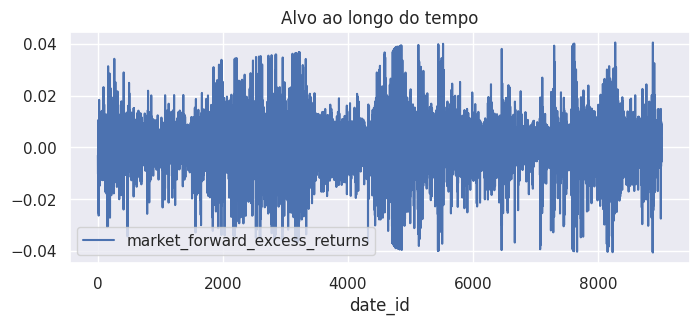

In [36]:
# Série temporal do alvo por date_id (se existir)
if "date_id" in train.columns:
    train.plot(x="date_id", y=target_col, kind="line", figsize=(8, 3), title="Alvo ao longo do tempo")
    plt.show()

**Nota (alvo e alocação):**
- Alvo fixo = retorno em excesso do mercado (`market_forward_excess_returns`) conforme definição oficial; fallback para `target`/`forward_returns` cria a coluna de excesso se necessário.
- Conversão `pred -> allocation`: `allocation = clip(1 + k * pred, 0, 2)` com `k` calibrado via Sharpe CV; clipping mantém a alocação entre 0 e 2.
- A avaliação usa a métrica oficial de Sharpe ajustado aplicada a essas alocações.

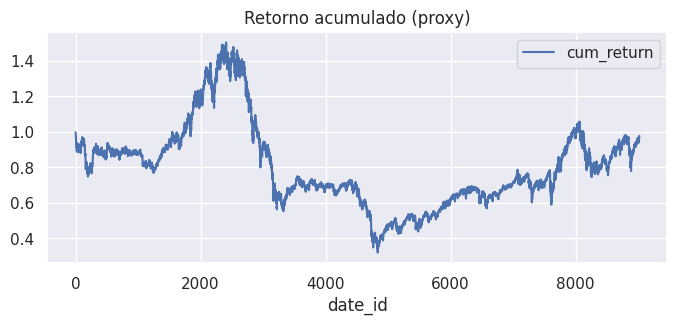

In [37]:
# Série temporal de retornos acumulados (simples) como sanity check
if "date_id" in train.columns:
    tmp = train.sort_values("date_id")[["date_id", target_col]].copy()
    tmp["cum_return"] = (1 + tmp[target_col].fillna(0)).cumprod()
    tmp.plot(x="date_id", y="cum_return", kind="line", figsize=(8, 3), title="Retorno acumulado (proxy)")
    plt.show()

## 5. Diagnóstico rápido

Top 10 colunas com mais NaN:
E7     0.772531
V10    0.670547
S3     0.635517
M1     0.614899
M13    0.614123
M14    0.614123
M6     0.559029
V9     0.503159
S12    0.392085
M5     0.363929
dtype: float64

Distribuição do alvo:
count    9021.000000
mean        0.000053
std         0.010558
min        -0.040582
25%        -0.004747
50%         0.000255
75%         0.005479
max         0.040551
Name: market_forward_excess_returns, dtype: float64


Text(0.5, 1.0, 'Distribuição do alvo')

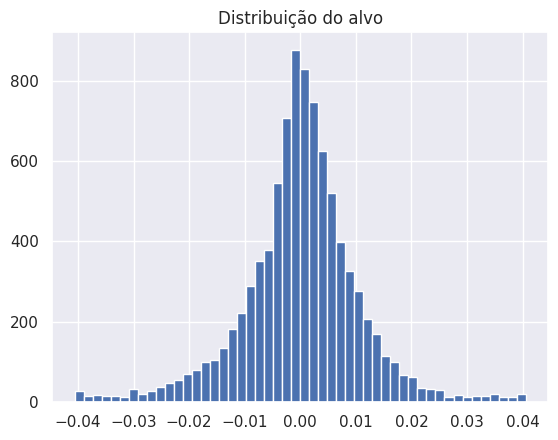

In [38]:
missing = train.isna().mean().sort_values(ascending=False)
print("Top 10 colunas com mais NaN:")
print(missing.head(10))

print("\nDistribuição do alvo:")
print(train[target_col].describe())
_ = train[target_col].hist(bins=50)
plt.title("Distribuição do alvo")

In [39]:
# Checagem rápida de is_scored (se existir)
if "is_scored" in train.columns:
    print("is_scored value counts:\n", train["is_scored"].value_counts())
    if "date_id" in train.columns:
        tmp = train.groupby(["date_id", "is_scored"]).size().unstack(fill_value=0)
        print("\nRegistros por date_id e is_scored (top 5):")
        print(tmp.head())

## 6. Correlação rápida e famílias de features

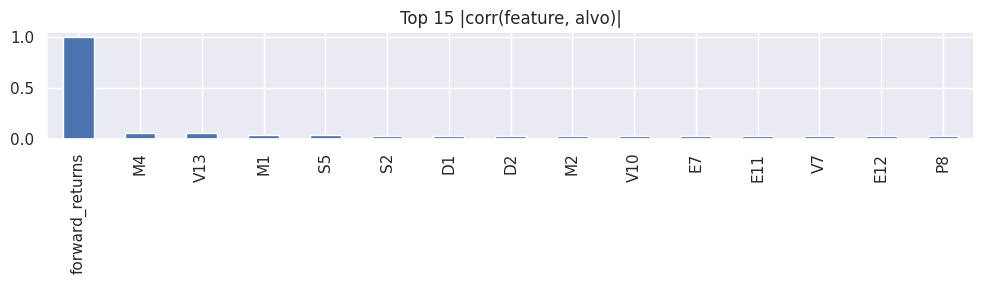

Top 15 correlações Spearman (alvo):


,spearman
forward_returns,0.999881
M1,0.053104
M4,-0.053103
V13,0.046438
S2,-0.044806
V10,0.043996
P5,-0.041314
S5,0.039138
V7,0.036789
E19,0.035005


In [40]:
# Top correlações absolutas com o alvo (informam direção das features mais úteis)
numeric_cols = train.select_dtypes(include=[np.number]).columns
feature_pool = [c for c in numeric_cols if c not in {target_col, "row_id"}]
top_corr = train[feature_pool].corrwith(train[target_col]).abs().sort_values(ascending=False).head(15)
top_corr.plot(kind="bar", figsize=(10, 3), title="Top 15 |corr(feature, alvo)|")
plt.tight_layout()
plt.show()

# Spearman (ordem por sinal de monotonicidade)
top_spearman = (
    train[feature_pool]
    .corrwith(train[target_col], method="spearman")
    .sort_values(key=lambda s: s.abs(), ascending=False)
    .head(15)
)
print("Top 15 correlações Spearman (alvo):")
display(top_spearman.to_frame("spearman"))

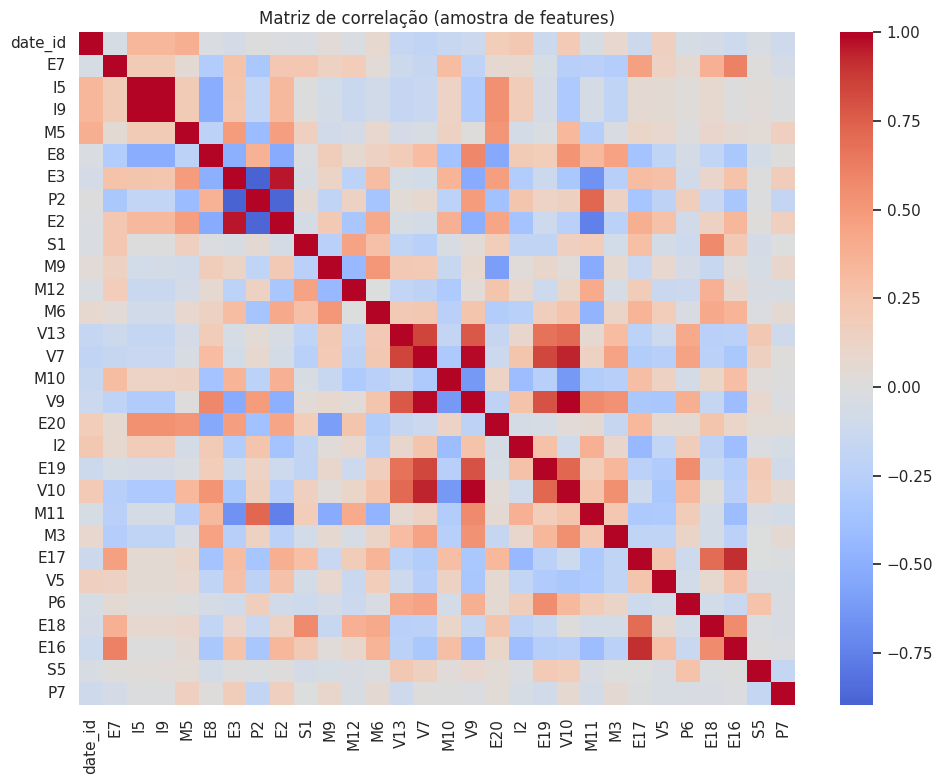

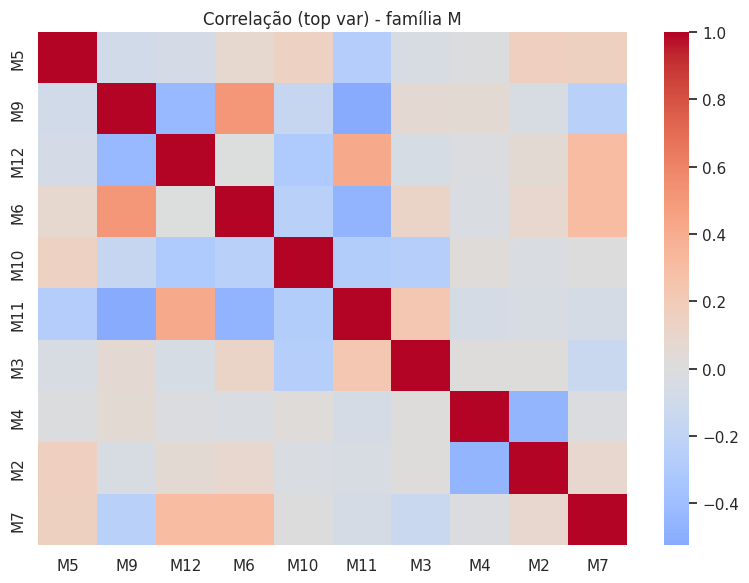

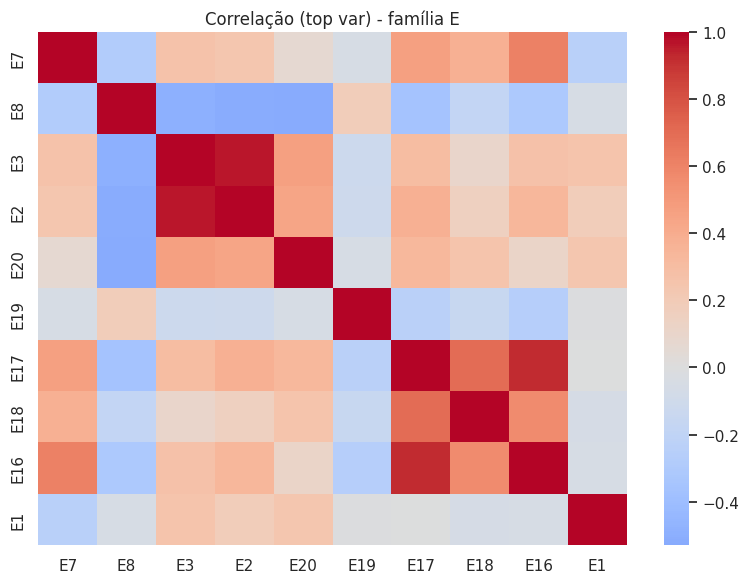

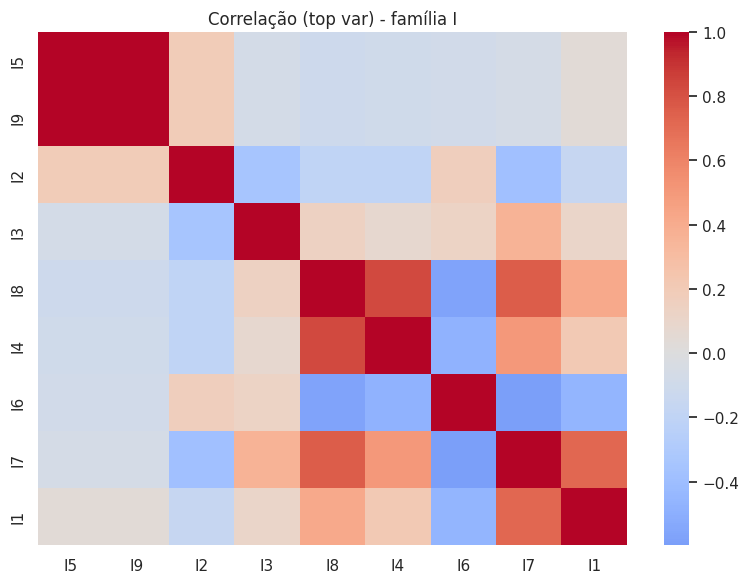

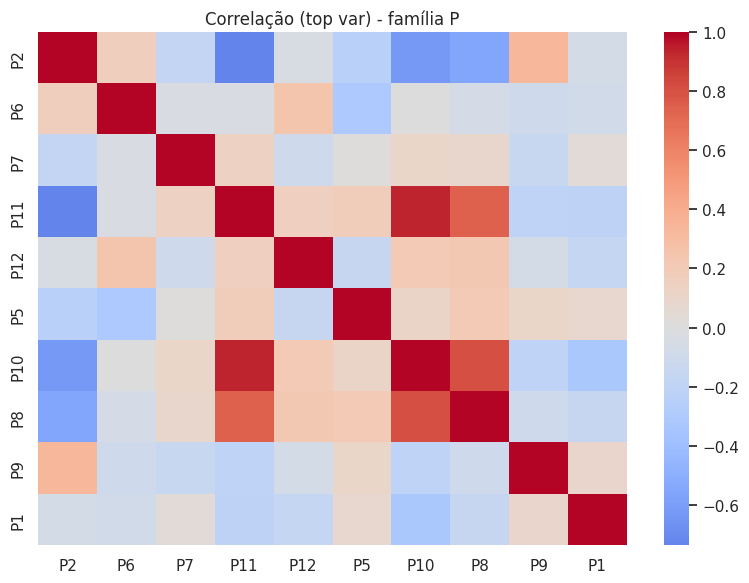

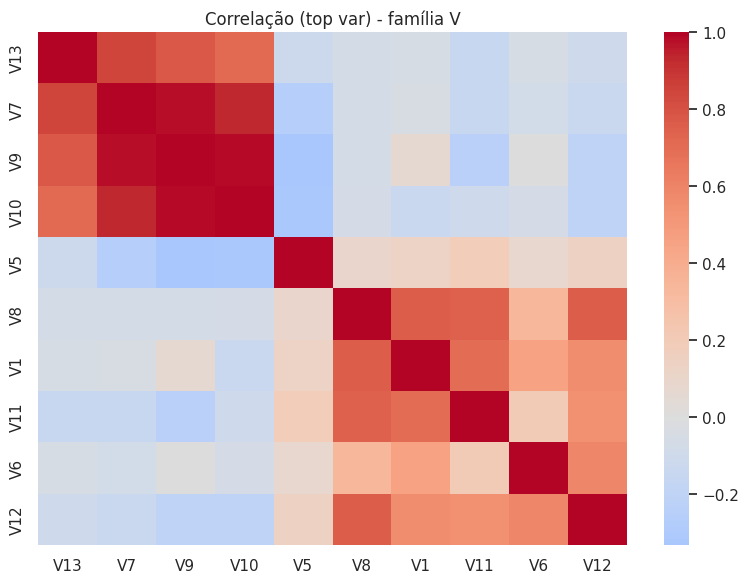

In [41]:
# Colinearidade: matriz de correlação (top 30 por variância) para observar redundância
var_sorted = train[feature_pool].var().sort_values(ascending=False)
sample_cols = var_sorted.head(min(30, len(var_sorted))).index.tolist()
corr_sample = train[sample_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_sample, cmap="coolwarm", center=0)
plt.title("Matriz de correlação (amostra de features)")
plt.tight_layout()
plt.show()

# Heatmaps menores por família (top 10 por variância em cada grupo)
families = {g: [c for c in feature_pool if c.startswith(g)] for g in ["M", "E", "I", "P", "V"]}
for fam, cols in families.items():
    if len(cols) < 3:
        continue
    var_sorted_fam = train[cols].var().sort_values(ascending=False)
    fam_cols = var_sorted_fam.head(min(10, len(var_sorted_fam))).index.tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(train[fam_cols].corr(), cmap="coolwarm", center=0)
    plt.title(f"Correlação (top var) - família {fam}")
    plt.tight_layout()
    plt.show()

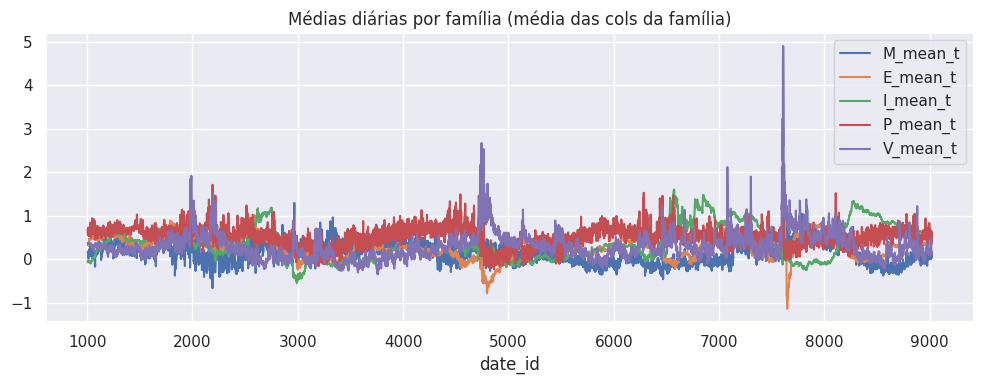

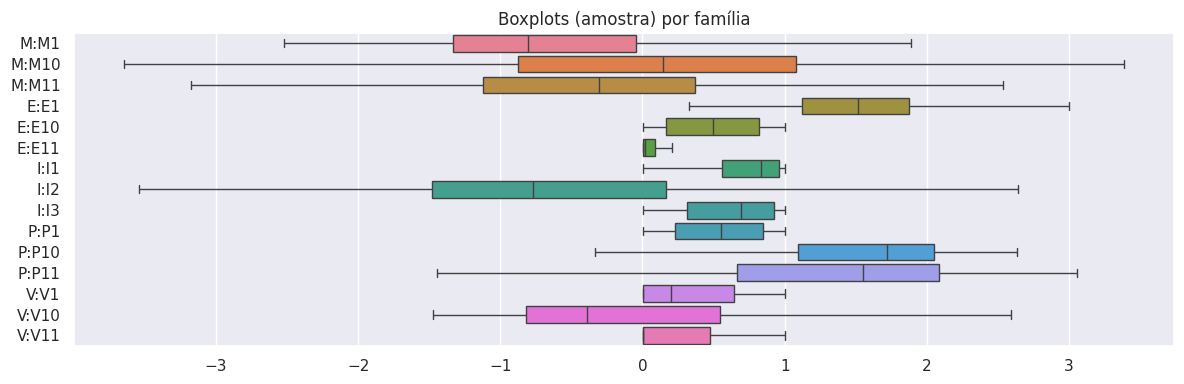

In [42]:
# Distribuições e cortes por família ao longo do tempo (médias diárias)
fams = {g: [c for c in feature_pool if c.startswith(g)] for g in ["M", "E", "I", "P", "V"]}
if "date_id" in train.columns:
    fam_means = {}
    for fam, cols in fams.items():
        if not cols:
            continue
        fam_means[f"{fam}_mean_t"] = train.groupby("date_id")[cols].mean().mean(axis=1)
    if fam_means:
        fam_df = pd.DataFrame(fam_means)
        fam_df.plot(figsize=(10, 4), title="Médias diárias por família (média das cols da família)")
        plt.tight_layout()
        plt.show()
    # Boxplot por família (amostra) para ver dispersão
    box_data = []
    for fam, cols in fams.items():
        take = cols[:3]
        for col in take:
            box_data.append(train[col].dropna().sample(min(5000, train[col].dropna().shape[0]), random_state=SEED).rename(f"{fam}:{col}"))
    if box_data:
        combined = pd.concat(box_data, axis=1)
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=combined, orient="h", showfliers=False)
        plt.title("Boxplots (amostra) por família")
        plt.tight_layout()
        plt.show()

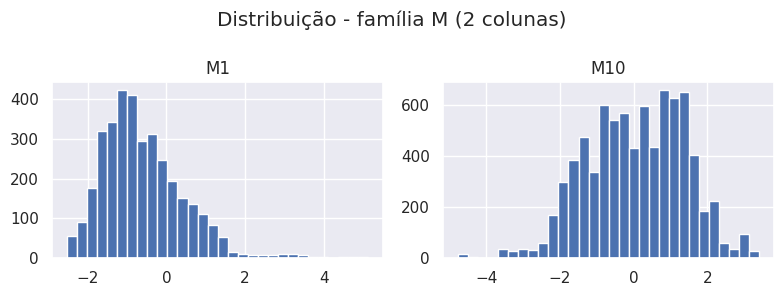

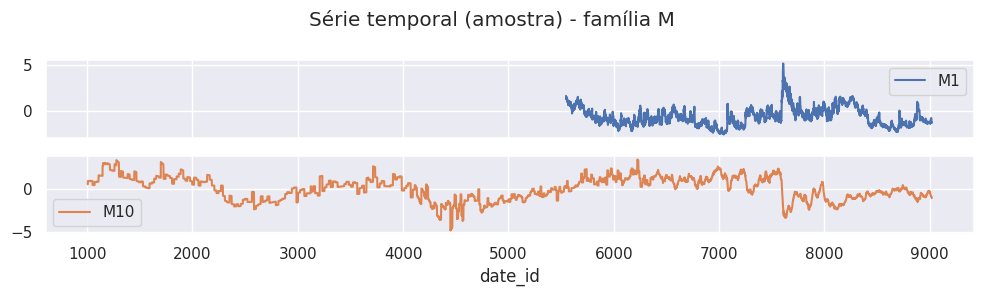

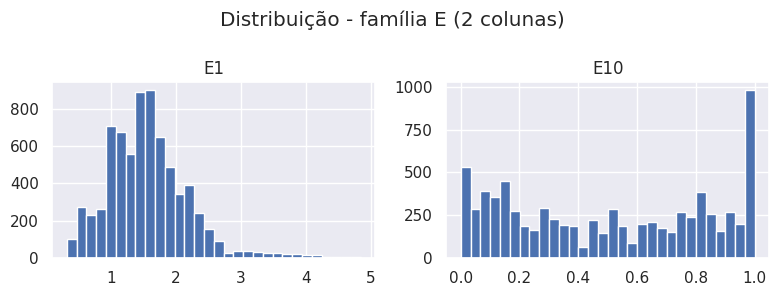

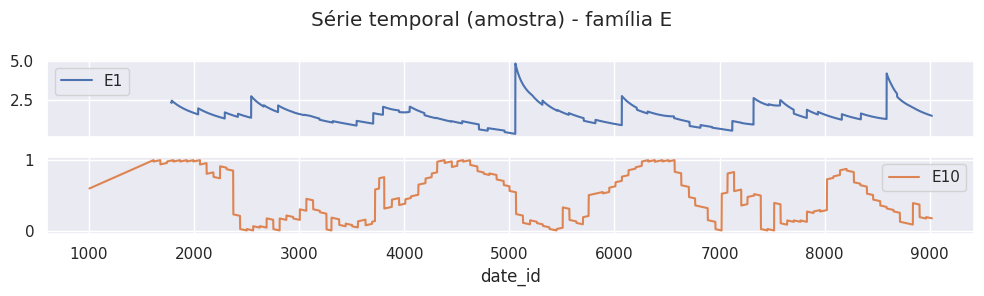

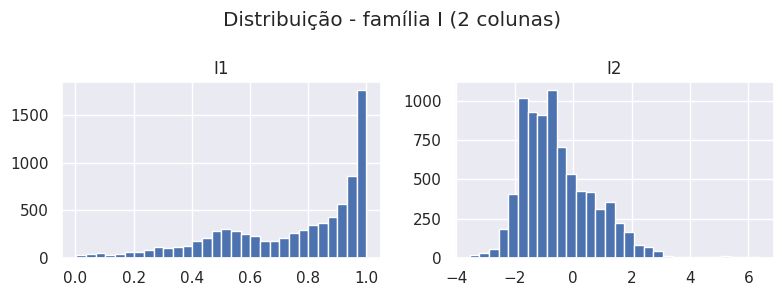

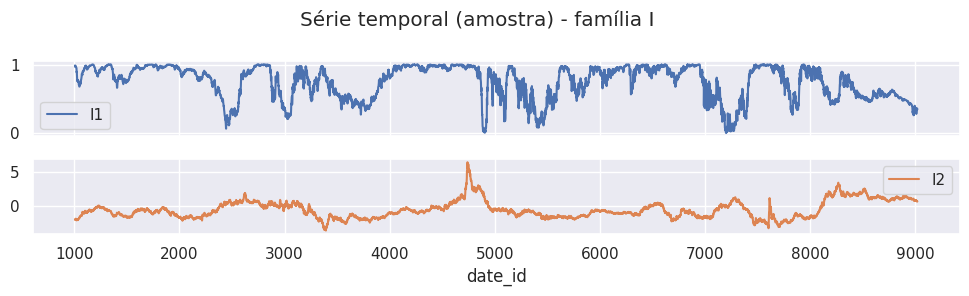

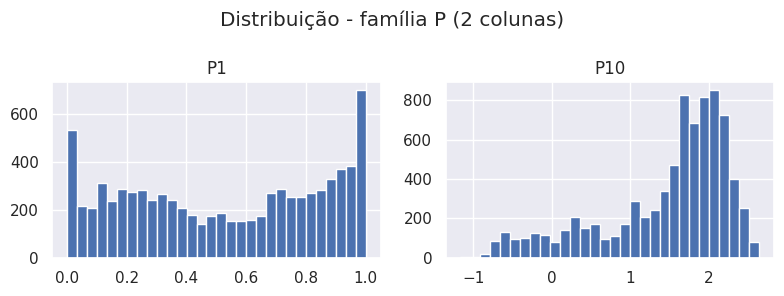

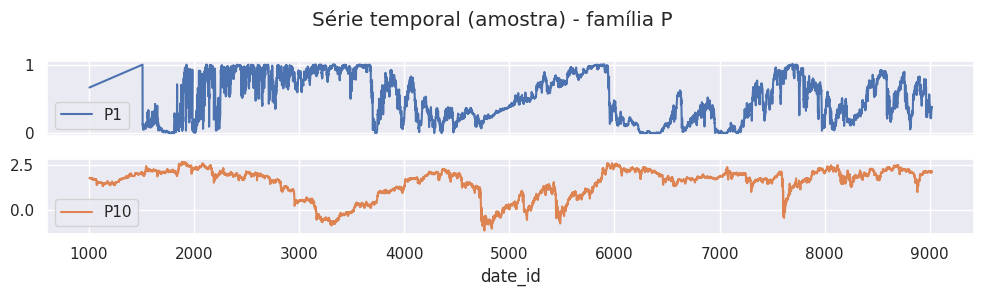

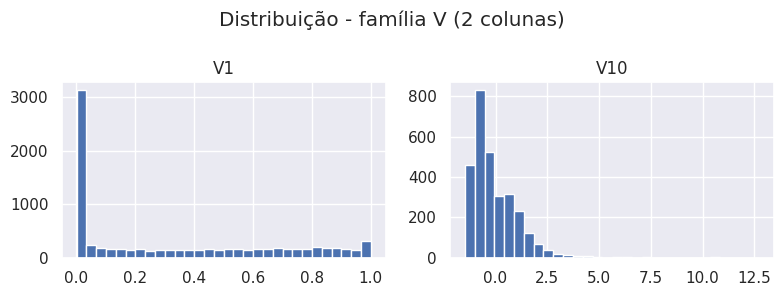

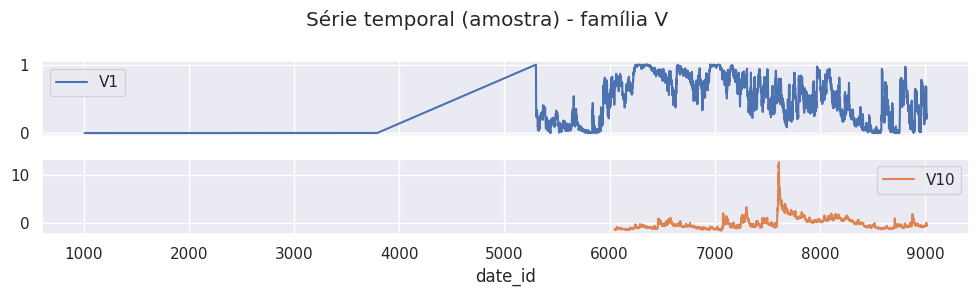

In [43]:
# Amostra de colunas por família (M/E/I/P/V): histograma rápido para escala/dispersão
families = {g: [c for c in feature_pool if c.startswith(g)] for g in ["M", "E", "I", "P", "V"]}
for fam, cols in families.items():
    take = cols[:2]
    if not take:
        continue
    train[take].hist(bins=30, figsize=(8, 3))
    plt.suptitle(f"Distribuição - família {fam} (2 colunas)")
    plt.tight_layout()
    plt.show()
    if "date_id" in train.columns:
        tmp = train.sort_values("date_id")[["date_id"] + take]
        tmp.set_index("date_id")[take].plot(subplots=True, figsize=(10, 3), title=f"Série temporal (amostra) - família {fam}")
        plt.tight_layout()
        plt.show()

### Comparações train vs test e regimes

Médias/volatilidades por família (train vs test):


split,test,train
family,,
E,0.353741,0.271369
I,0.485636,0.387901
M,0.071712,0.049919
P,0.571983,0.508921
V,0.256438,0.281485


split,test,train
family,,
E,0.034466,0.752711
I,0.021977,0.699944
M,0.167596,0.888994
P,0.227315,0.774633
V,0.095981,0.682188


<Figure size 800x300 with 0 Axes>

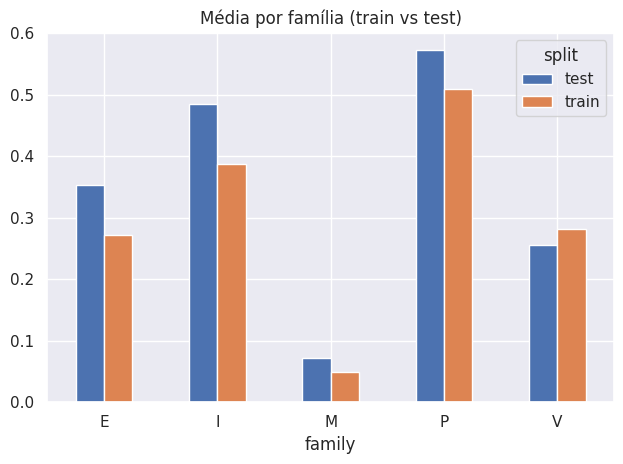

<Figure size 800x300 with 0 Axes>

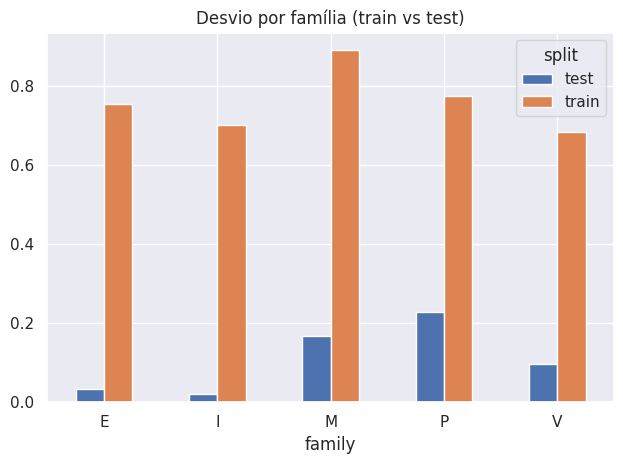

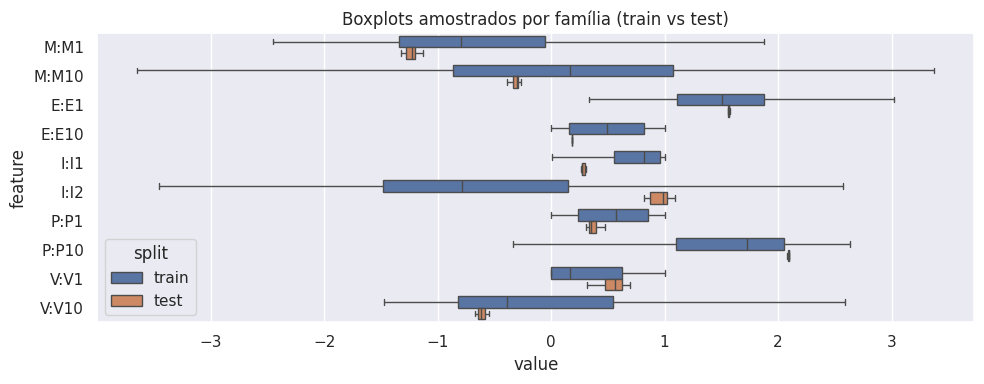

In [44]:
fam_stats_rows = []
for split_name, df_split in [("train", train), ("test", test)]:
    for fam, cols in families.items():
        cols_use = [c for c in cols if c in df_split.columns]
        if not cols_use:
            continue
        fam_stats_rows.append(
            {
                "split": split_name,
                "family": fam,
                "mean": float(df_split[cols_use].mean().mean()),
                "std": float(df_split[cols_use].std(ddof=0).mean()),
            }
        )
fam_stats_df = pd.DataFrame(fam_stats_rows)
if not fam_stats_df.empty:
    print("Médias/volatilidades por família (train vs test):")
    display(fam_stats_df.pivot(index="family", columns="split", values="mean"))
    display(fam_stats_df.pivot(index="family", columns="split", values="std"))
    plt.figure(figsize=(8, 3))
    fam_stats_df.pivot(index="family", columns="split", values="mean").plot(kind="bar", rot=0, title="Média por família (train vs test)")
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 3))
    fam_stats_df.pivot(index="family", columns="split", values="std").plot(kind="bar", rot=0, title="Desvio por família (train vs test)")
    plt.tight_layout()
    plt.show()

# Boxplots comparando train/test (amostra) para 2 cols por família
box_rows = []
for split_name, df_split in [("train", train), ("test", test)]:
    for fam, cols in families.items():
        take = [c for c in cols if c in df_split.columns][:2]
        for col in take:
            series = df_split[col].dropna()
            if series.empty:
                continue
            sample = series.sample(min(3000, len(series)), random_state=SEED)
            box_rows.append(pd.DataFrame({"value": sample, "feature": f"{fam}:{col}", "split": split_name}))
if box_rows:
    box_df = pd.concat(box_rows, axis=0)
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=box_df, x="value", y="feature", hue="split", showfliers=False)
    plt.title("Boxplots amostrados por família (train vs test)")
    plt.tight_layout()
    plt.show()

# Distribuição de retornos defasados do mercado e features de regime
lag_col = "lagged_market_forward_excess_returns" if "lagged_market_forward_excess_returns" in train.columns else None
if lag_col:
    plt.figure(figsize=(8, 3))
    train[lag_col].hist(bins=40, alpha=0.6, label="train")
    if lag_col in test.columns:
        test[lag_col].hist(bins=40, alpha=0.6, label="test")
    plt.title(f"Distribuição {lag_col} (train/test)")
    plt.legend()
    plt.tight_layout()
    plt.show()
for reg_col in ["regime_std_20", "regime_high_vol"]:
    if reg_col in train.columns:
        plt.figure(figsize=(8, 3))
        train[reg_col].hist(bins=40, alpha=0.6, label=f"{reg_col} train")
        if reg_col in test.columns:
            test[reg_col].hist(bins=40, alpha=0.6, label=f"{reg_col} test")
        plt.title(f"Distribuição {reg_col} (train/test)")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Impacto de regime_high_vol (quando existir)
if "regime_high_vol" in train.columns:
    grp = train.groupby(train["regime_high_vol"].fillna(0))[[target_col]]
    impact_df = grp.agg(["mean", "std"]).rename_axis("regime_high_vol")
    print("Alvo por regime_high_vol (train):")
    display(impact_df)

**Insights EDA (anotar)**
- Famílias com maiores médias/vol no train vs test; olhar barras acima para detectar shifts.
- Features mais correlacionadas (Pearson/Spearman) e se mantêm estáveis nos boxplots train/test.
- Regime_high_vol e lagged_market_forward_excess_returns: checar distribuição e impacto no Sharpe/target; ajustar features/intencional se houver drift.

## 7. Preparação de features

In [45]:
def prepare_features(df, target):
    sort_key = "date_id" if "date_id" in df.columns else None
    df_sorted = df.sort_values(sort_key) if sort_key else df.copy()
    if df_sorted.columns.has_duplicates:
        df_sorted = df_sorted.loc[:, ~df_sorted.columns.duplicated()]
    numeric_cols = df_sorted.select_dtypes(include=[np.number]).columns.tolist()
    drop_cols = {target, "row_id", "forward_returns", "risk_free_rate", "market_forward_excess_returns"}
    for col in ["date_id", "is_scored"]:
        if col in df_sorted.columns:
            drop_cols.add(col)
    feature_cols = [c for c in numeric_cols if c not in drop_cols]
    # Remove colunas constantes
    feature_cols = [c for c in feature_cols if df_sorted[c].nunique() > 1]
    return df_sorted, feature_cols


def preprocess_basic(df, feature_cols, ref_cols=None):
    feature_cols = list(dict.fromkeys(feature_cols))
    feature_frame = df.reindex(columns=feature_cols)
    medians = feature_frame.median()
    filled = feature_frame.fillna(medians).fillna(0)

    missing_mask = feature_frame.isna()
    if missing_mask.columns.has_duplicates:
        missing_mask = missing_mask.loc[:, ~missing_mask.columns.duplicated()]
    flag_source_cols = []
    for c in feature_cols:
        mask_c = missing_mask[c]
        has_nan = mask_c.any().any() if isinstance(mask_c, pd.DataFrame) else bool(mask_c.any())
        if has_nan:
            flag_source_cols.append(c)
    flags_df = None
    if flag_source_cols:
        flag_unique = list(dict.fromkeys(flag_source_cols))
        flags_df = missing_mask[flag_unique].astype(int)
        flags_df.columns = [f"{c}_was_nan" for c in flag_unique]

    parts = [filled]
    if flags_df is not None:
        parts.append(flags_df)
    df_proc = pd.concat(parts, axis=1)

    if df_proc.columns.has_duplicates:
        df_proc = df_proc.loc[:, ~df_proc.columns.duplicated()]
    keep = [col for col in df_proc.columns if df_proc[col].std(ddof=0) > 1e-9]
    out = df_proc[keep] if ref_cols is None else df_proc.reindex(columns=ref_cols, fill_value=0)
    return out, list(out.columns)


def time_split(df, cutoff=0.8):
    n = int(len(df) * cutoff)
    return df.iloc[:n].copy(), df.iloc[n:].copy()


def append_columns(df, cols_dict):
    """Concatena colunas derivadas de forma única para evitar fragmentação."""
    if not cols_dict:
        return df
    new_df = pd.DataFrame(cols_dict, index=df.index)
    combined = pd.concat([df, new_df], axis=1)
    if combined.columns.has_duplicates:
        combined = combined.loc[:, ~combined.columns.duplicated(keep="last")]
    return combined


def add_missing_columns(df, columns, fill_value=np.nan):
    """Garante colunas ausentes em lote (evita fragmentação de DataFrame)."""
    missing = [c for c in columns if c not in df.columns]
    if not missing:
        return df
    filler = {c: fill_value for c in missing}
    return append_columns(df, filler)


def align_feature_frames(train_df, other_df, feature_cols):
    """
    Garante alinhamento de colunas entre treino/val/test antes do preprocess_basic:
    - remove duplicadas mantendo a última ocorrência;
    - adiciona colunas faltantes;
    - descarta features completamente NaN ou constantes no treino.
    Retorna dataframes alinhados e a lista de features válida.
    """
    cols_unique = list(dict.fromkeys(feature_cols))
    train_clean = train_df.copy()
    if train_clean.columns.has_duplicates:
        train_clean = train_clean.loc[:, ~train_clean.columns.duplicated(keep="last")]

    other_clean = None
    if other_df is not None:
        other_clean = other_df.copy()
        if other_clean.columns.has_duplicates:
            other_clean = other_clean.loc[:, ~other_clean.columns.duplicated(keep="last")]

    train_clean = add_missing_columns(train_clean, cols_unique)
    if other_clean is not None:
        other_clean = add_missing_columns(other_clean, cols_unique)

    valid_cols = []
    for c in cols_unique:
        series = train_clean[c]
        if isinstance(series, pd.DataFrame):
            series = series.iloc[:, 0]
        if series.isna().all():
            continue
        if series.std(ddof=0) <= 1e-12:
            continue
        valid_cols.append(c)

    train_clean = add_missing_columns(train_clean, valid_cols)
    if other_clean is not None:
        other_clean = add_missing_columns(other_clean, valid_cols)
    return train_clean, other_clean, valid_cols


def add_lagged_market_features(df):
    """Adiciona colunas lagged_* para alinhar train/test com as features defasadas do teste."""
    if "date_id" not in df.columns:
        return df
    out = df.copy()
    df_sorted = df.sort_values("date_id")
    new_cols = {}

    def add_shift(src_col, dest_col):
        if dest_col in out.columns or src_col not in df_sorted.columns:
            return
        shifted = df_sorted[src_col].shift(1).reindex(df.index)
        new_cols[dest_col] = shifted

    add_shift("forward_returns", "lagged_forward_returns")
    add_shift("risk_free_rate", "lagged_risk_free_rate")
    add_shift("market_forward_excess_returns", "lagged_market_forward_excess_returns")
    return append_columns(out, new_cols)


def add_family_aggs(df):
    df_out = df.copy()
    fams = {g: [c for c in df_out.columns if c.startswith(g)] for g in ["M", "E", "I", "P", "V"]}
    new_cols = {}
    for fam, cols in fams.items():
        cols = [c for c in cols if pd.api.types.is_numeric_dtype(df_out[c])]
        if len(cols) >= 2:
            new_cols[f"{fam}_mean"] = df_out[cols].mean(axis=1)
            new_cols[f"{fam}_std"] = df_out[cols].std(axis=1)
            new_cols[f"{fam}_median"] = df_out[cols].median(axis=1)
    return append_columns(df_out, new_cols)


def add_regime_features(df):
    """Cria features de regime baseadas em retornos defasados do mercado."""
    if "date_id" not in df.columns:
        return df
    df_out = df.copy()
    df_sorted = df.sort_values("date_id")
    new_cols = {}
    base_series = None
    if "lagged_market_forward_excess_returns" in df_sorted.columns:
        base_series = df_sorted["lagged_market_forward_excess_returns"]
    elif "market_forward_excess_returns" in df_sorted.columns:
        base_series = df_sorted["market_forward_excess_returns"].shift(1)
    if base_series is None:
        return df

    roll_mean_5 = base_series.rolling(window=5, min_periods=1).mean()
    roll_std_20 = base_series.rolling(window=20, min_periods=5).std()
    roll_mean_20 = base_series.rolling(window=20, min_periods=5).mean()

    new_cols["regime_mean_5"] = roll_mean_5.reindex(df.index)
    new_cols["regime_std_20"] = roll_std_20.reindex(df.index)
    new_cols["regime_mean_20"] = roll_mean_20.reindex(df.index)
    new_cols["regime_high_vol"] = (roll_std_20 > roll_std_20.median()).astype(float).reindex(df.index)
    new_cols["regime_trend_up"] = (roll_mean_20 > 0).astype(float).reindex(df.index)
    return append_columns(df_out, new_cols)


def add_intentional_features(df, intentional_cfg=None):
    """Features específicas da competição: excessos defasados, transforms e clipping determinístico."""
    cfg = dict(INTENTIONAL_CFG)
    if intentional_cfg:
        cfg.update(intentional_cfg)

    clip_low, clip_high = cfg.get("clip_bounds", (-0.05, 0.05))
    tanh_scale = cfg.get("tanh_scale", 1.0)
    zscore_window = int(cfg.get("zscore_window", 20))
    zscore_clip = cfg.get("zscore_clip", None)

    df_out = df.copy()
    new_cols = {}
    base_series = None
    if "lagged_market_forward_excess_returns" in df_out.columns:
        base_series = df_out["lagged_market_forward_excess_returns"]
    elif "market_forward_excess_returns" in df_out.columns and "date_id" in df_out.columns:
        tmp = df_out.sort_values("date_id")["market_forward_excess_returns"].shift(1)
        base_series = tmp.reindex(df_out.index)
        new_cols["lagged_market_forward_excess_returns"] = base_series

    if base_series is not None:
        base_series = base_series.reindex(df_out.index)
        new_cols["lagged_market_excess_clip"] = base_series.clip(clip_low, clip_high)
        new_cols["lagged_market_excess_tanh"] = np.tanh(base_series * tanh_scale)
        new_cols["lagged_market_excess_sq"] = np.square(base_series)
        new_cols["lagged_market_excess_sign"] = np.sign(base_series)

        # z-score defasado com janela ajustável
        min_periods = max(3, zscore_window // 2)
        roll_std = base_series.rolling(window=zscore_window, min_periods=min_periods).std()
        z_vals = (base_series / roll_std.replace(0, np.nan)).fillna(0)
        if zscore_clip is not None:
            z_vals = z_vals.clip(-float(zscore_clip), float(zscore_clip))
        new_cols["lagged_market_excess_z"] = z_vals

    if "lagged_forward_returns" in df_out.columns and "lagged_risk_free_rate" in df_out.columns:
        new_cols["lagged_excess_return"] = df_out["lagged_forward_returns"] - df_out["lagged_risk_free_rate"]

    # Logs de variáveis de volatilidade (se positivas)
    v_cols = [c for c in df_out.columns if c.startswith("V")]
    for c in v_cols:
        series = df_out[c]
        try:
            all_positive = bool(np.all(series > 0))
        except Exception:
            all_positive = False
        if all_positive:
            new_cols[c + "_log1p"] = np.log1p(series)
    return append_columns(df_out, new_cols)


def winsorize_skewed_features(df, target, fe_cfg, fit_ref=None):
    """Aplica winsor/clipping bilateral em features muito skewed para reduzir outliers. Se fit_ref é fornecido, usa quantis do treino."""
    df_out = df.copy()
    ref = df if fit_ref is None else fit_ref
    q = fe_cfg.get("winsor_quantile")
    skew_thr = fe_cfg.get("skew_threshold", 3.0)
    if q is None or q <= 0.5 or q >= 1:
        return df_out
    drop_cols = {target, "row_id", "date_id", "forward_returns", "risk_free_rate", "market_forward_excess_returns"}
    num_cols = [c for c in ref.select_dtypes(include=[np.number]).columns if c not in drop_cols]
    new_cols = {}

    def _first_series(obj):
        if isinstance(obj, pd.Series):
            return obj
        if isinstance(obj, pd.DataFrame):
            return obj.iloc[:, 0]
        return pd.Series(obj)

    for col in num_cols:
        if col not in df_out.columns:
            continue
        series_ref = _first_series(ref[col])
        series = _first_series(df_out[col])
        if series.std(ddof=0) <= 0 or series.isna().all():
            continue
        skew_val = series_ref.skew(skipna=True)
        if np.isnan(skew_val) or abs(skew_val) < skew_thr:
            continue
        lo = series_ref.quantile(1 - q)
        hi = series_ref.quantile(q)
        new_cols[col] = series.clip(lo, hi)
    return df_out.assign(**new_cols) if new_cols else df_out


def add_ratio_diff_features(df, fe_cfg):
    """Adiciona razões e diferenças simples entre agregados de famílias."""
    df_out = df.copy()
    fams = ["M", "E", "I", "P", "V"]
    new_cols = {}
    def _to_series(obj):
        if isinstance(obj, pd.DataFrame):
            return obj.iloc[:, 0]
        return obj
    if fe_cfg.get("add_ratios", True) or fe_cfg.get("add_diffs", True):
        for fam in fams:
            mean_col = f"{fam}_mean"
            std_col = f"{fam}_std"
            median_col = f"{fam}_median"
            if fe_cfg.get("add_ratios", True) and mean_col in df_out and std_col in df_out:
                mean_ser = _to_series(df_out[mean_col])
                std_ser = _to_series(df_out[std_col])
                denom = std_ser.replace(0, np.nan)
                new_cols[f"{fam}_mean_over_std"] = (mean_ser / denom).fillna(0)
            if fe_cfg.get("add_diffs", True) and mean_col in df_out and std_col in df_out:
                mean_ser = _to_series(df_out[mean_col])
                std_ser = _to_series(df_out[std_col])
                new_cols[f"{fam}_mean_minus_std"] = (mean_ser - std_ser).fillna(0)
            if fe_cfg.get("add_ratios", True) and mean_col in df_out and median_col in df_out:
                mean_ser = _to_series(df_out[mean_col])
                med_ser = _to_series(df_out[median_col])
                new_cols[f"{fam}_mean_minus_median"] = (mean_ser - med_ser).fillna(0)
    return append_columns(df_out, new_cols)


def apply_feature_engineering(df, target, fe_cfg=None, fit_ref=None):
    """Pipeline parametrizável de engenharia (winsor, ratios/diffs, medianas por família). fit_ref permite aplicar quantis do treino no val/test."""
    cfg = dict(FEATURE_CFG_DEFAULT)
    if fe_cfg:
        cfg.update(fe_cfg)
    df_out = df.copy()
    df_out = winsorize_skewed_features(df_out, target, cfg, fit_ref=fit_ref)
    df_out = add_ratio_diff_features(df_out, cfg)
    return df_out


def add_finance_combos(df):
    """Combinações simples de fatores: spreads e interações com risco/vol."""
    df_out = df.copy()
    df_out = df_out.loc[:, ~df_out.columns.duplicated()]  # evita misalignment por labels duplicados
    new_cols = {}
    def _to_series(obj):
        if isinstance(obj, pd.DataFrame):
            return obj.iloc[:, 0]
        return obj
    # Spreads de retorno defasado vs. mercado
    if "lagged_excess_return" in df_out.columns and "lagged_market_forward_excess_returns" in df_out.columns:
        lhs = _to_series(df_out["lagged_excess_return"])
        rhs = _to_series(df_out["lagged_market_forward_excess_returns"])
        new_cols["lagged_excess_minus_market"] = lhs - rhs
    if "lagged_market_forward_excess_returns" in df_out.columns and "risk_free_rate" in df_out.columns:
        lhs = _to_series(df_out["lagged_market_forward_excess_returns"])
        rhs = _to_series(df_out["risk_free_rate"])
        new_cols["lagged_market_minus_rf"] = lhs - rhs
    # Combinações de médias por família (se existirem)
    fam_pairs = [("M_mean", "V_mean"), ("P_mean", "E_mean")]
    for a, b in fam_pairs:
        if a in df_out.columns and b in df_out.columns:
            lhs = _to_series(df_out[a])
            rhs = _to_series(df_out[b])
            new_cols[f"{a}_minus_{b}"] = lhs - rhs
            denom = rhs.replace(0, np.nan)
            new_cols[f"{a}_over_{b}"] = (lhs / denom).fillna(0)
    return append_columns(df_out, new_cols)


def add_cross_sectional_norms(df):
    """Normalização cross-section por dia para colunas numéricas (z-score por família)."""
    if "date_id" not in df.columns:
        return df
    df_out = df.copy()
    families = {g: [c for c in df_out.columns if c.startswith(g) and pd.api.types.is_numeric_dtype(df_out[c])] for g in ["M", "E", "I", "P", "V"]}
    new_cols = {}
    for fam, cols in families.items():
        if not cols:
            continue
        grp = df_out.groupby("date_id")[cols]
        mean = grp.transform("mean")
        std = grp.transform("std").replace(0, np.nan)
        new_cols.update({f"{c}_cs_z": ((df_out[c] - mean[c]) / std[c]).fillna(0) for c in cols})
    return append_columns(df_out, new_cols)


def add_surprise_features(df):
    """Surprise = desvio do valor atual vs média rolling 5/20 da própria feature (para colunas numéricas)."""
    if "date_id" not in df.columns:
        return df
    df_sorted = df.loc[:, ~df.columns.duplicated()].sort_values("date_id")
    num_cols = [c for c in df_sorted.columns if pd.api.types.is_numeric_dtype(df_sorted[c]) and c not in {"date_id"}]
    new_cols = {}
    for col in num_cols:
        series = df_sorted[col]
        if series.isna().all():
            continue
        roll5 = series.rolling(window=5, min_periods=3).mean()
        roll20 = series.rolling(window=20, min_periods=5).mean()
        new_cols[f"{col}_surprise_5"] = (series - roll5).reindex(df.index)
        new_cols[f"{col}_surprise_20"] = (series - roll20).reindex(df.index)
    return append_columns(df, new_cols)


def build_feature_sets(df, target, intentional_cfg=None, fe_cfg=None, fit_ref=None):
    df = df.loc[:, ~df.columns.duplicated()]
    orig_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    df_eng = add_lagged_market_features(df)
    df_eng = add_family_aggs(df_eng)
    df_eng = add_regime_features(df_eng)
    df_eng = add_intentional_features(df_eng, intentional_cfg=intentional_cfg)
    df_eng = apply_feature_engineering(df_eng, target, fe_cfg=fe_cfg, fit_ref=fit_ref)
    df_eng = add_cross_sectional_norms(df_eng)
    df_eng = add_surprise_features(df_eng)
    df_eng = add_finance_combos(df_eng)
    if df_eng.columns.has_duplicates:
        df_eng = df_eng.loc[:, ~df_eng.columns.duplicated(keep="last")]
    df_eng, all_cols = prepare_features(df_eng, target)

    base_cols = [c for c in orig_numeric if c in all_cols]
    if not base_cols:
        base_cols = all_cols

    agg_cols = [c for c in df_eng.columns if c.endswith("_mean") or c.endswith("_std")]
    regime_cols = [c for c in df_eng.columns if c.startswith("regime_")]
    intentional_cols = [c for c in df_eng.columns if any(k in c for k in ["lagged_excess_return", "lagged_market_excess", "_log1p", "_clip", "_tanh", "_z"])]

    feature_sets = {
        "A_baseline": sorted(set(base_cols)),
        "B_families": sorted(set(base_cols + agg_cols)),
        "C_regimes": sorted(set(base_cols + agg_cols + regime_cols)),
        "D_intentional": sorted(set(base_cols + agg_cols + regime_cols + intentional_cols)),
    }
    if fe_cfg is None:
        fe_cfg = FEATURE_CFG_DEFAULT
    if fe_cfg.get("use_extended_set", True):
        oriented_cols = [c for c in all_cols if c not in feature_sets["D_intentional"]]
        feature_sets["E_fe_oriented"] = sorted(set(feature_sets["D_intentional"] + oriented_cols))
        new_cols = [c for c in all_cols if c not in feature_sets["E_fe_oriented"]]
        feature_sets["F_v2_intentional"] = sorted(set(feature_sets["E_fe_oriented"] + new_cols))
    return df_eng, feature_sets


def make_features(
    train_df,
    test_df=None,
    target_col=TARGET_COL,
    feature_set=None,
    intentional_cfg=None,
    fe_cfg=None,
):
    """
    Pipeline único de features para todos os fluxos (CV, diagnósticos e treino final):
    - lags, agregações por família, regimes, features intencionais;
    - winsor/clipping, razões/diferenças, normalização cross-section, surprise features, combos financeiros;
    - aplica o mesmo fit de FE no teste via fit_ref.
    Retorna dataframes engenheirados (ainda não normalizados pelo preprocess_basic), lista de colunas do feature set escolhido e o dict de feature sets.
    """
    train_fe, feature_sets = build_feature_sets(train_df, target_col, intentional_cfg=intentional_cfg, fe_cfg=fe_cfg, fit_ref=None)
    test_fe = None
    if test_df is not None:
        test_fe, _ = build_feature_sets(test_df, target_col, intentional_cfg=intentional_cfg, fe_cfg=fe_cfg, fit_ref=train_fe)
    if feature_set is None:
        feature_set = "D_intentional" if "D_intentional" in feature_sets else next(iter(feature_sets))
    feature_cols = feature_sets.get(feature_set, next(iter(feature_sets.values())))
    return train_fe, test_fe, feature_cols, feature_sets, feature_set


def build_features(
    train_df,
    test_df=None,
    target_col=TARGET_COL,
    feature_set=None,
    intentional_cfg=None,
    fe_cfg=None,
):
    """Alias para manter compatibilidade com chamadas antigas; delega para make_features."""
    return make_features(
        train_df,
        test_df=test_df,
        target_col=target_col,
        feature_set=feature_set,
        intentional_cfg=intentional_cfg,
        fe_cfg=fe_cfg,
    )

In [ ]:
# Helpers para materializar módulos (Kaggle/offline)
import sys
import textwrap
from pathlib import Path


def materialize_package(src_dir: Path, dest_dir: Path) -> None:
    """Copia um pacote inteiro para o working dir (útil no Kaggle offline)."""
    if dest_dir.exists():
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)
    print(f"Pacote {dest_dir} materializado de {src_dir}")


# Materializa o pacote hull_tactical (features + models) para uso no notebook/Kaggle
PACKAGE_SRC = Path("src/hull_tactical")
PACKAGE_DEST = Path("hull_tactical")
if PACKAGE_SRC.exists():
    materialize_package(PACKAGE_SRC, PACKAGE_DEST)
else:
    raise FileNotFoundError("src/hull_tactical não encontrado; garanta que o repo está completo.")

sys.path.insert(0, '.')
from hull_tactical.features import *  # noqa: F401,F403

import hull_tactical.models as hm
from hull_tactical import pipeline
from hull_tactical.models import (  # noqa: F401,F403
    evaluate_baselines,
    constant_allocation_cv,
    time_cv_lightgbm_fitref,
    make_time_splits,
    compute_strategy_returns,
    map_return_to_alloc,
    adjusted_sharpe_score,
    optimize_allocation_scale,
    time_cv_lightgbm,
    sanity_shuffle_test,
    clipping_sensitivity,
    summarize_cv_metrics,
    make_sample_weight,
    time_cv_lightgbm_weighted,
    stability_check,
    run_cv_preds,
    calibrate_k_from_cv_preds,
    expanding_holdout_eval,
    choose_scored_strategy,
    compute_sharpe_weights,
    blend_and_eval,
    train_full_and_predict_model,
    prepare_train_test_frames,
    add_exp_log,
    set_data_columns,
)

hm.set_data_columns(MARKET_COL, RF_COL, IS_SCORED_COL)
hm.INTENTIONAL_CFG = INTENTIONAL_CFG
hm.FEATURE_CFG_DEFAULT = FEATURE_CFG_DEFAULT
hm.BEST_PARAMS = BEST_PARAMS
hm.ALLOC_K = ALLOC_K
hm.MIN_INVESTMENT = MIN_INVESTMENT
hm.MAX_INVESTMENT = MAX_INVESTMENT

# Pipeline de alto nível (mantém notebook alinhado ao src/hull_tactical)
PIPELINE_FEATURE_SET = "D_intentional"
PIPELINE_CFG = hm.default_config()


def run_pipeline_allocations(feature_set: str = PIPELINE_FEATURE_SET, cfg=None):
    cfg_use = cfg or PIPELINE_CFG
    return pipeline.train_pipeline(
        df_train=train,
        df_test=test,
        feature_set=feature_set,
        cfg=cfg_use,
    )

## 8. Validação temporal (Sharpe ajustado oficial)
Métrica principal = Sharpe ajustado local. RMSE só é usado como diagnóstico secundário em cortes simples.

In [51]:
intentional_tuning_grid = [
    {"name": "base_clip", **INTENTIONAL_DEFAULTS},
    {"name": "soft_clip_z15", "clip_bounds": (-0.04, 0.04), "tanh_scale": 1.15, "zscore_window": 15, "zscore_clip": 4.0},
    {"name": "wide_clip_z25", "clip_bounds": (-0.06, 0.06), "tanh_scale": 0.9, "zscore_window": 25, "zscore_clip": 6.0},
]
intentional_cv_results = {}
intentional_summary_rows = []
for cfg in intentional_tuning_grid:
    cfg_name = cfg.get("name", f"cfg_{len(intentional_summary_rows)}")
    print(f"\nConfig intencional: {cfg_name} -> {cfg}")
    cfg_use = hm.default_config()
    cfg_use.intentional_cfg = {**INTENTIONAL_CFG, **cfg}
    metrics_cfg = pipeline.run_time_cv(train, feature_set="D_intentional", target_col=target_col, cfg=cfg_use, n_splits=4, val_frac=0.12)
    intentional_cv_results[cfg_name] = metrics_cfg
    summary_cfg = summarize_cv_metrics(metrics_cfg) or {}
    summary_cfg.update(
        {
            "config": cfg_name,
            "clip_bounds": cfg.get("clip_bounds"),
            "tanh_scale": cfg.get("tanh_scale"),
            "zscore_window": cfg.get("zscore_window"),
            "zscore_clip": cfg.get("zscore_clip"),
        }
    )
    intentional_summary_rows.append(summary_cfg)

intentional_summary_df = pd.DataFrame(intentional_summary_rows)
best_cfg = None
if not intentional_summary_df.empty and intentional_summary_df["sharpe_mean"].notna().any():
    best_idx = intentional_summary_df["sharpe_mean"].astype(float).idxmax()
    best_cfg = intentional_tuning_grid[int(best_idx)]
    INTENTIONAL_CFG = {**INTENTIONAL_CFG, **best_cfg}
    PIPELINE_CFG.intentional_cfg = INTENTIONAL_CFG
    PIPELINE_CFG.feature_cfg = PIPELINE_CFG.feature_cfg or FEATURE_CFG_DEFAULT
    print(f"\nMelhor config para features intencionais: {best_cfg.get('name')} | Sharpe={intentional_summary_df.loc[best_idx, 'sharpe_mean']:.4f}")
    print(f"INTENTIONAL_CFG atualizada: {INTENTIONAL_CFG}")
    display(intentional_summary_df[["config", "sharpe_mean", "sharpe_std", "k_median", "alpha_median", "clip_bounds", "tanh_scale", "zscore_window", "zscore_clip"]])
else:
    print("Calibração não retornou métricas; mantendo defaults.")

intentional_folds_rows = []
for cfg_name, metrics in intentional_cv_results.items():
    for m in metrics:
        intentional_folds_rows.append(
            {
                "config": cfg_name,
                "fold": m.get("fold"),
                "sharpe": m.get("sharpe"),
                "k": m.get("best_k"),
                "alpha": m.get("best_alpha"),
                "n_scored": m.get("n_scored"),
            }
        )
intentional_folds_df = pd.DataFrame(intentional_folds_rows)
if not intentional_folds_df.empty:
    display(intentional_folds_df.pivot(index="fold", columns="config", values="sharpe"))


Config intencional: base_clip -> {'name': 'base_clip', 'clip_bounds': (-0.05, 0.05), 'tanh_scale': 1.0, 'zscore_window': 20, 'zscore_clip': 5.0}
Fold 1: Sharpe_adj=0.1033 | alpha=0.50 | k=2.50 | vol=11.63 | const=0.0450 | iter=11 | n_val=902 | n_scored=902
Fold 2: Sharpe_adj=1.0485 | alpha=1.00 | k=2.50 | vol=15.18 | const=1.0485 | iter=1 | n_val=902 | n_scored=902
Fold 3: Sharpe_adj=0.8413 | alpha=1.00 | k=0.00 | vol=12.67 | const=0.8413 | iter=12 | n_val=902 | n_scored=902
Fold 4: Sharpe_adj=0.8301 | alpha=1.00 | k=2.50 | vol=18.34 | const=0.8300 | iter=20 | n_val=902 | n_scored=902
Média Sharpe (folds): 0.7058 | baseline const: 0.6912

Config intencional: soft_clip_z15 -> {'name': 'soft_clip_z15', 'clip_bounds': (-0.04, 0.04), 'tanh_scale': 1.15, 'zscore_window': 15, 'zscore_clip': 4.0}
Fold 1: Sharpe_adj=0.1033 | alpha=0.50 | k=2.50 | vol=11.63 | const=0.0450 | iter=11 | n_val=902 | n_scored=902
Fold 2: Sharpe_adj=1.0485 | alpha=1.00 | k=2.50 | vol=15.18 | const=1.0485 | iter=1 | 

,config,sharpe_mean,sharpe_std,k_median,alpha_median,clip_bounds,tanh_scale,zscore_window,zscore_clip
0,base_clip,0.705808,0.358559,2.5,1.0,"(-0.05, 0.05)",1.00,20,5.0
1,soft_clip_z15,0.705809,0.358559,2.5,1.0,"(-0.04, 0.04)",1.15,15,4.0
2,wide_clip_z25,0.705807,0.358558,2.5,1.0,"(-0.06, 0.06)",0.90,25,6.0


config,base_clip,soft_clip_z15,wide_clip_z25
fold,,,
1,0.103316,0.103316,0.103316
2,1.048527,1.048527,1.048527
3,0.841275,0.841275,0.841275
4,0.830115,0.830118,0.830108


In [52]:
# Executa CV temporal usando pipeline unificado de features
train_fe_all, test_fe_all, feature_cols_main, feature_sets, main_feature_set = make_features(
    train,
    test_df=test,
    target_col=target_col,
    feature_set="D_intentional",
    intentional_cfg=INTENTIONAL_CFG,
    fe_cfg=FEATURE_CFG_DEFAULT,
)
_df = train_fe_all
# Contagem de features por set
feat_counts = pd.DataFrame(
    [{"feature_set": name, "n_features": len(cols)} for name, cols in feature_sets.items()]
).sort_values("n_features", ascending=False)
print("Número de features por conjunto:")
display(feat_counts)

feature_cols_cv = feature_sets.get(main_feature_set, next(iter(feature_sets.values())))
print(f"Feature set principal para variações rápidas: {main_feature_set} ({len(feature_cols_cv)} cols)")
# Alias para compatibilidade com células seguintes
feature_cols = feature_cols_cv

cv_metrics = {}
stability_reports = {}
for name, cols in feature_sets.items():
    print(f"\n==== CV para {name} ({len(cols)} features) ====")
    cv_metrics[name] = pipeline.run_time_cv(train, feature_set=name, target_col=target_col, cfg=PIPELINE_CFG, n_splits=5, val_frac=0.10)
    sanity_shuffle_test(_df, cols, target_col, n_splits=3)
    stability_reports[name] = stability_check(_df, cols, target_col, configs=[(5, 0.1), (4, 0.15), (6, 0.10)])

Número de features por conjunto:


,feature_set,n_features
4,E_fe_oriented,735
5,F_v2_intentional,735
3,D_intentional,460
2,C_regimes,133
1,B_families,118
0,A_baseline,94


Feature set principal para variações rápidas: D_intentional (460 cols)

==== CV para A_baseline (94 features) ====
Fold 1: Sharpe_adj=0.1034 | alpha=0.50 | k=2.50 | vol=11.63 | const=0.0450 | iter=148 | n_val=902 | n_scored=902
Fold 2: Sharpe_adj=1.0485 | alpha=1.00 | k=2.50 | vol=15.18 | const=1.0485 | iter=1 | n_val=902 | n_scored=902
Fold 3: Sharpe_adj=0.8413 | alpha=1.00 | k=0.00 | vol=12.67 | const=0.8413 | iter=1 | n_val=902 | n_scored=902
Fold 4: Sharpe_adj=0.8301 | alpha=1.00 | k=2.50 | vol=18.34 | const=0.8300 | iter=19 | n_val=902 | n_scored=902
Fold 5: Sharpe_adj=0.4392 | alpha=1.00 | k=2.50 | vol=16.86 | const=0.4392 | iter=10 | n_val=902 | n_scored=902
Média Sharpe (folds): 0.6525 | baseline const: 0.6408
Fold 1: Sharpe_adj=0.1033 | alpha=0.50 | k=2.50 | vol=11.63 | const=0.0450 | iter=6 | n_val=902 | n_scored=902
Fold 2: Sharpe_adj=1.0485 | alpha=1.00 | k=0.00 | vol=15.19 | const=1.0485 | iter=34 | n_val=902 | n_scored=902
Fold 3: Sharpe_adj=0.8413 | alpha=1.00 | k=0.00 |

### Visualização rápida dos folds

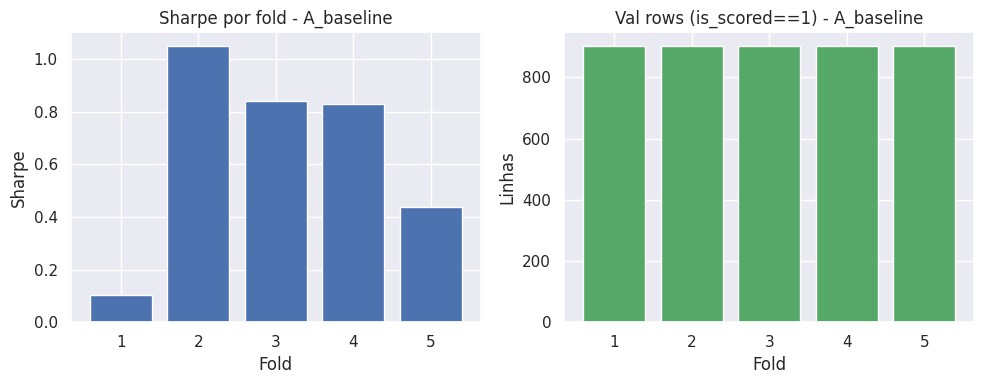

A_baseline: Sharpe médio=0.6525 | desvio=0.3379
A_baseline: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


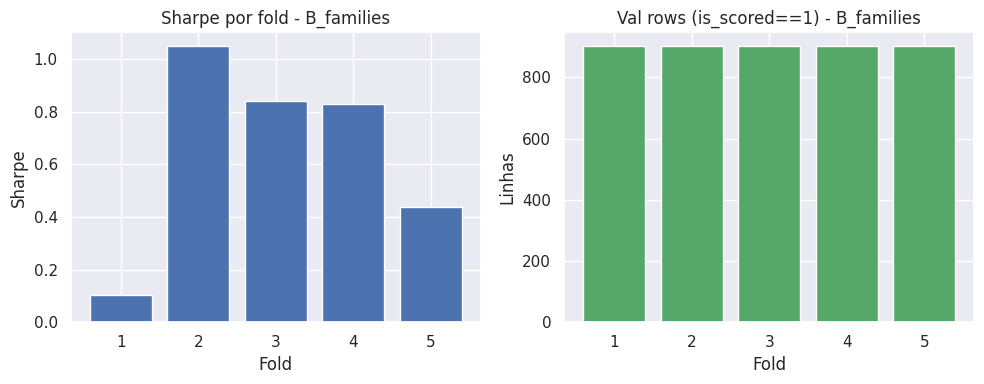

B_families: Sharpe médio=0.6525 | desvio=0.3379
B_families: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


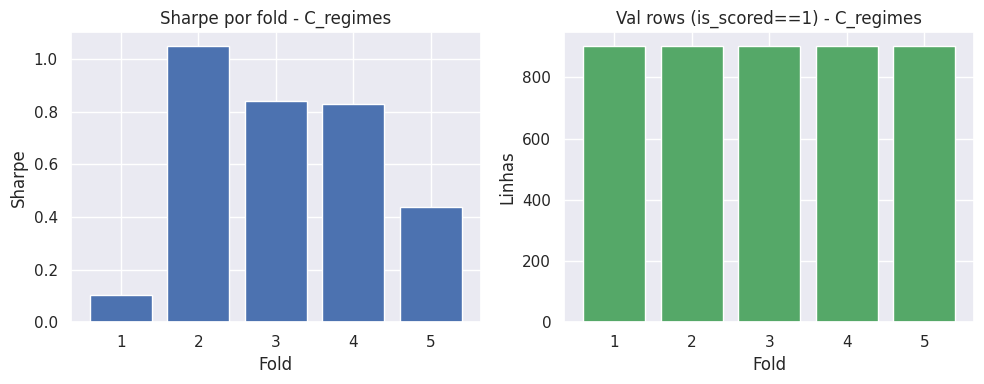

C_regimes: Sharpe médio=0.6525 | desvio=0.3380
C_regimes: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


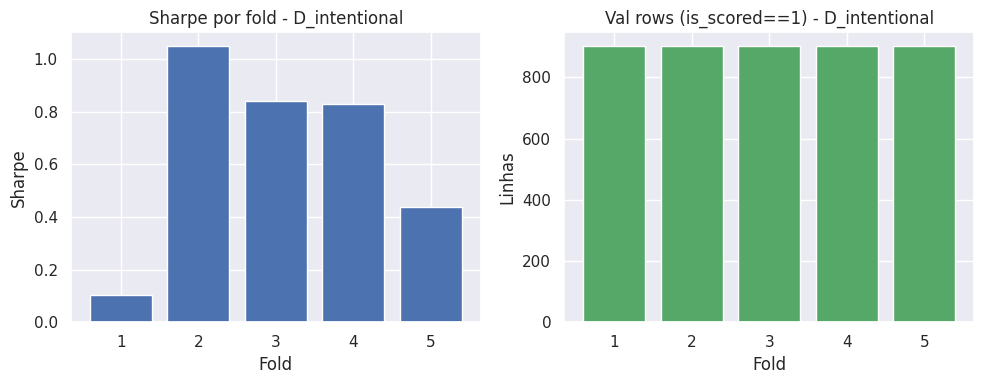

D_intentional: Sharpe médio=0.6525 | desvio=0.3380
D_intentional: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


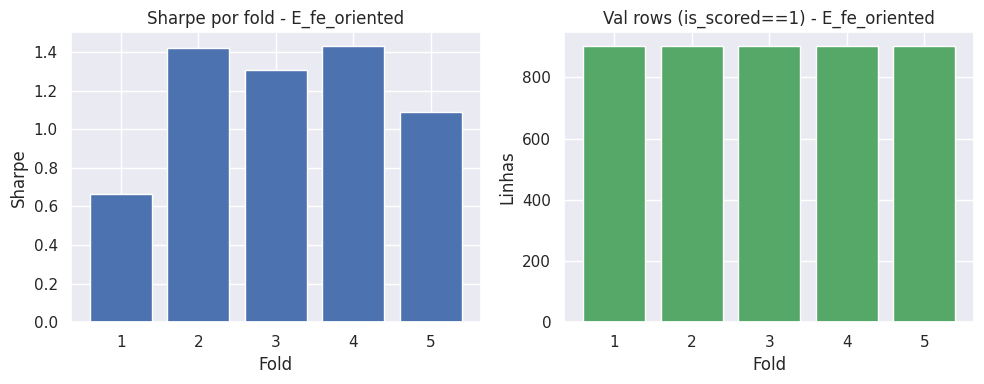

E_fe_oriented: Sharpe médio=1.1818 | desvio=0.2855
E_fe_oriented: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


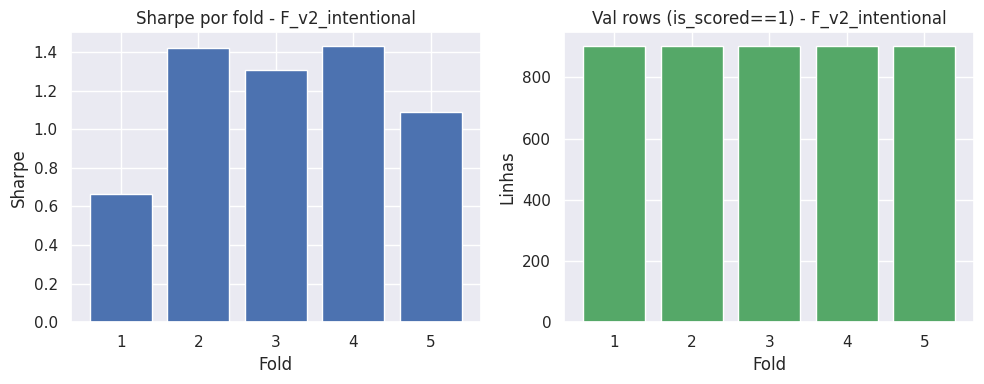

F_v2_intentional: Sharpe médio=1.1818 | desvio=0.2855
F_v2_intentional: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


In [53]:
import matplotlib.pyplot as plt

for name, metrics in cv_metrics.items():
    if not metrics:
        continue
    df_cv = pd.DataFrame(metrics)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(df_cv["fold"], df_cv["sharpe"], color="#4C72B0")
    axes[0].set_title(f"Sharpe por fold - {name}")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Sharpe")
    axes[1].bar(df_cv["fold"], df_cv["n_scored"], color="#55A868")
    axes[1].set_title(f"Val rows (is_scored==1) - {name}")
    axes[1].set_xlabel("Fold")
    axes[1].set_ylabel("Linhas")
    plt.tight_layout()
    plt.show()

    sharpe_vals = [m["sharpe"] for m in metrics]
    n_scored_vals = df_cv["n_scored"]
    print(f"{name}: Sharpe médio={np.mean(sharpe_vals):.4f} | desvio={np.std(sharpe_vals):.4f}")
    print(f"{name}: n_scored fold (min/med/max) = {int(n_scored_vals.min())}/{int(n_scored_vals.median())}/{int(n_scored_vals.max())}")
    print("Para robustez, teste n_splits=3 e n_splits=6 e compare.")

### CV com engenharia recalculada por fold (fit_ref)
Recalcula winsor/clipping/z-score e intenções usando apenas o treino de cada fold (reduz risco de olhar distribuição futura).

In [54]:
print("\n=== CV (fit_ref por fold) usando D_intentional ===")
metrics_fitref = pipeline.run_time_cv_fitref(
    train, feature_set="D_intentional", target_col=target_col, cfg=PIPELINE_CFG, n_splits=4, val_frac=0.12, num_boost_round=180
)
if metrics_fitref:
    df_fitref = pd.DataFrame(metrics_fitref)
    display(df_fitref)
    print(f"Sharpe médio (fit_ref): {df_fitref['sharpe'].mean():.4f} | std={df_fitref['sharpe'].std():.4f}")
else:
    print("CV fit_ref não retornou métricas (cheque date_id / is_scored).")


=== CV (fit_ref por fold) usando D_intentional ===
[fit_ref] Fold 1: Sharpe_adj=0.7424 | alpha=0.50 | k=2.50 | n_scored=1082
[fit_ref] Fold 2: Sharpe_adj=1.3125 | alpha=0.50 | k=2.50 | n_scored=1082
[fit_ref] Fold 3: Sharpe_adj=1.3276 | alpha=0.50 | k=2.50 | n_scored=1082
[fit_ref] Fold 4: Sharpe_adj=1.3013 | alpha=0.50 | k=2.50 | n_scored=1082
[fit_ref] Sharpe médio: 1.1710


,fold,sharpe,best_k,best_alpha,n_scored,strategy_vol
0,1,0.742379,2.5,0.5,1082,11.673841
1,2,1.312540,2.5,0.5,1082,6.583600
2,3,1.327561,2.5,0.5,1082,7.977553
3,4,1.301321,2.5,0.5,1082,8.090853


Sharpe médio (fit_ref): 1.1710 | std=0.2859


### LGBM variantes (peso is_scored e modelo conservador)
- Peso para is_scored: treina dando menor peso para linhas não pontuadas.
- Modelo conservador: configuração com mais regularização para compor ensemble.

In [55]:
print("\n=== CV LGBM ponderado por is_scored (peso_non_scored=0.2) ===")
metrics_weighted = pipeline.run_time_cv(
    train,
    feature_set=PIPELINE_FEATURE_SET,
    target_col=target_col,
    cfg=PIPELINE_CFG,
    n_splits=4,
    val_frac=0.12,
    num_boost_round=180,
    weight_scored=1.0,
    weight_unscored=0.2,
    log_prefix="[weighted]",
)
if metrics_weighted:
    print(f"Sharpe médio (weighted): {np.mean([m['sharpe'] for m in metrics_weighted]):.4f}")

params_conservative = {
    "num_leaves": 31,
    "learning_rate": 0.03,
    "min_data_in_leaf": 300,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
}
print("\n=== CV LGBM conservador (mais regularização) ===")
metrics_cons = pipeline.run_time_cv(
    train,
    feature_set=PIPELINE_FEATURE_SET,
    target_col=target_col,
    cfg=PIPELINE_CFG,
    n_splits=4,
    val_frac=0.12,
    params_override=params_conservative,
    num_boost_round=180,
    early_stopping_rounds=15,
    log_prefix="[cons]",
)
if metrics_cons:
    print(f"Sharpe médio (conservador): {np.mean([m['sharpe'] for m in metrics_cons]):.4f}")


=== CV LGBM ponderado por is_scored (peso_non_scored=0.2) ===
[weighted] Fold 1: Sharpe_adj=0.1956 | alpha=0.50 | k=2.50 | vol=11.71 | const=0.1385 | iter=71 | n_val=1082 | n_scored=1082
[weighted] Fold 2: Sharpe_adj=0.8263 | alpha=1.00 | k=2.50 | vol=13.21 | const=0.8263 | iter=23 | n_val=1082 | n_scored=1082
[weighted] Fold 3: Sharpe_adj=0.9494 | alpha=1.00 | k=0.00 | vol=16.10 | const=0.9494 | iter=4 | n_val=1082 | n_scored=1082
[weighted] Fold 4: Sharpe_adj=0.6751 | alpha=1.00 | k=0.00 | vol=16.24 | const=0.6751 | iter=1 | n_val=1082 | n_scored=1082
[weighted] Média Sharpe (folds): 0.6616 | baseline const: 0.6473
Sharpe médio (weighted): 0.6616

=== CV LGBM conservador (mais regularização) ===
Fold 1: Sharpe_adj=0.1962 | alpha=0.50 | k=2.50 | vol=11.71 | const=0.1385 | iter=36 | n_val=1082 | n_scored=1082
Fold 2: Sharpe_adj=0.8265 | alpha=1.00 | k=2.50 | vol=13.21 | const=0.8263 | iter=23 | n_val=1082 | n_scored=1082
Fold 3: Sharpe_adj=0.9494 | alpha=1.00 | k=2.50 | vol=16.10 | co

### Resumo padronizado de CV (Sharpe ajustado + n_scored)

In [56]:
cv_summary_rows = []
for name, metrics in cv_metrics.items():
    summary = summarize_cv_metrics(metrics)
    if summary:
        summary.update({"feature_set": name, "config": "n_splits=5 | val_frac=0.10", "n_features": len(feature_sets.get(name, []))})
        cv_summary_rows.append(summary)
for name, reports in stability_reports.items():
    for rep in reports:
        row = dict(rep)
        row.update({"feature_set": name, "config": f"n_splits={rep['n_splits']} | val_frac={rep['val_frac']:.2f}", "n_features": len(feature_sets.get(name, []))})
        cv_summary_rows.append(row)
cv_summary_df = pd.DataFrame(cv_summary_rows)
if not cv_summary_df.empty:
    cols_order = [
        "feature_set",
        "config",
        "n_features",
        "sharpe_mean",
        "sharpe_std",
        "k_median",
        "alpha_median",
        "n_scored_min",
        "n_scored_med",
        "n_scored_max",
        "const_sharpe_mean",
        "folds",
    ]
    display(cv_summary_df[cols_order])

,feature_set,config,n_features,sharpe_mean,sharpe_std,k_median,alpha_median,n_scored_min,n_scored_med,n_scored_max,const_sharpe_mean,folds
0,A_baseline,n_splits=5 | val_frac=0.10,94,0.652500,0.337937,2.5,1.0,902,902,902,0.640803,5
1,B_families,n_splits=5 | val_frac=0.10,118,0.652508,0.337928,2.5,1.0,902,902,902,0.640803,5
2,C_regimes,n_splits=5 | val_frac=0.10,133,0.652495,0.337965,2.5,1.0,902,902,902,0.640803,5
3,D_intentional,n_splits=5 | val_frac=0.10,460,0.652484,0.337973,2.5,1.0,902,902,902,0.640803,5
4,E_fe_oriented,n_splits=5 | val_frac=0.10,735,1.181793,0.285524,2.5,0.5,902,902,902,0.640803,5
5,F_v2_intentional,n_splits=5 | val_frac=0.10,735,1.181793,0.285524,2.5,0.5,902,902,902,0.640803,5
6,A_baseline,n_splits=5 | val_frac=0.10,94,0.652506,0.337929,2.5,1.0,902,902,902,0.640803,5
7,A_baseline,n_splits=4 | val_frac=0.15,94,0.631198,0.310723,2.5,1.0,1353,1353,1353,0.617755,3
8,A_baseline,n_splits=6 | val_frac=0.10,94,0.652506,0.337929,2.5,1.0,902,902,902,0.640803,5
9,B_families,n_splits=5 | val_frac=0.10,118,0.652508,0.337928,2.5,1.0,902,902,902,0.640803,5


### Comparação: feature sets D_intentional vs C_regimes (Sharpe local)

In [57]:
compare_sets = ["C_regimes", "D_intentional"]
comp_rows = []
for name in compare_sets:
    summary = summarize_cv_metrics(cv_metrics.get(name, []))
    if summary:
        summary.update({"feature_set": name, "config": "n_splits=5 | val_frac=0.10"})
        comp_rows.append(summary)
if comp_rows:
    comp_df = pd.DataFrame(comp_rows)
    cols_base = ["feature_set", "config", "sharpe_mean", "sharpe_std", "k_median", "alpha_median", "n_scored_med", "n_scored_min", "n_scored_max"]
    display(comp_df[cols_base])
    if set(compare_sets).issubset(set(comp_df["feature_set"])):
        sharpe_gain = (
            comp_df.loc[comp_df["feature_set"] == "D_intentional", "sharpe_mean"].values[0]
            - comp_df.loc[comp_df["feature_set"] == "C_regimes", "sharpe_mean"].values[0]
        )
        print(f"Ganho de Sharpe (D_intentional - C_regimes): {sharpe_gain:+.4f}")
else:
    print("CV ausente para algum dos conjuntos (C_regimes ou D_intentional). Rode as células de CV primeiro.")

,feature_set,config,sharpe_mean,sharpe_std,k_median,alpha_median,n_scored_med,n_scored_min,n_scored_max
0,C_regimes,n_splits=5 | val_frac=0.10,0.652495,0.337965,2.5,1.0,902,902,902
1,D_intentional,n_splits=5 | val_frac=0.10,0.652484,0.337973,2.5,1.0,902,902,902


Ganho de Sharpe (D_intentional - C_regimes): -0.0000


### Pseudo-leaderboard / holdout temporal (expanding window)
- Checa desempenho em um bloco final do histórico (10–15%) como proxy de LB pública.
- Compara treino completo vs. treino filtrado em `is_scored==1` nas avaliações.

In [58]:
def expanding_holdout_eval(
    df, feature_cols, target, holdout_frac=0.12, train_only_scored=False, label="holdout", use_weights=False, weight_unscored=0.2
):
    if "date_id" in df.columns:
        df_sorted = df.sort_values("date_id")
    else:
        df_sorted = df.copy()
    n_hold = max(1, int(len(df_sorted) * holdout_frac))
    train_part = df_sorted.iloc[:-n_hold]
    holdout_part = df_sorted.iloc[-n_hold:]
    if train_only_scored and IS_SCORED_COL and IS_SCORED_COL in train_part.columns:
        train_part = train_part.loc[train_part[IS_SCORED_COL] == 1]
    if len(train_part) == 0 or len(holdout_part) == 0:
        return None

    train_aligned, holdout_aligned, cols_use = align_feature_frames(train_part, holdout_part, feature_cols)
    tr_proc, keep_cols = preprocess_basic(train_aligned, cols_use)
    ho_proc, _ = preprocess_basic(holdout_aligned, cols_use, ref_cols=keep_cols)
    X_tr = tr_proc.drop(columns=[target], errors="ignore")
    y_tr = train_part[target]
    X_ho = ho_proc.drop(columns=[target], errors="ignore")

    train_weight = make_sample_weight(train_aligned, weight_scored=1.0, weight_unscored=weight_unscored) if use_weights else None
    params = {"objective": "regression", "metric": "rmse", **BEST_PARAMS}
    model = lgb.train(params, lgb.Dataset(X_tr, label=y_tr, weight=train_weight), num_boost_round=200)
    pred_ho = model.predict(X_ho)
    best_k, best_alpha, _ = optimize_allocation_scale(pred_ho, holdout_part, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL)
    alloc_ho = map_return_to_alloc(pred_ho, k=best_k, intercept=best_alpha)
    sharpe_ho, details = adjusted_sharpe_score(
        holdout_part, alloc_ho, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
    )
    return {
        "label": label,
        "holdout_frac": holdout_frac,
        "train_only_scored": train_only_scored,
        "sharpe_holdout": sharpe_ho,
        "k_best": best_k,
        "alpha_best": best_alpha,
        "n_train": len(train_part),
        "n_holdout": len(holdout_part),
        "n_scored_holdout": int(holdout_part[IS_SCORED_COL].sum()) if IS_SCORED_COL and IS_SCORED_COL in holdout_part.columns else len(holdout_part),
        "weight_unscored": weight_unscored if use_weights else None,
    }

### Treino scored vs. ponderado (is_scored) – comparação clara (full vs. scored_only vs. weighted)

In [59]:
is_scored_configs = [
    {"name": "full", "train_only_scored": False, "weight_unscored": 1.0},
    {"name": "weighted_0.2", "train_only_scored": False, "weight_unscored": 0.2},
    {"name": "scored_only", "train_only_scored": True, "weight_unscored": None},
]

is_scored_results = []
for cfg in is_scored_configs:
    print(f"\n=== CV is_scored cfg={cfg['name']} ===")
    metrics_cfg = pipeline.run_time_cv(
        train,
        feature_set=PIPELINE_FEATURE_SET,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=4,
        val_frac=0.12,
        weight_scored=1.0,
        weight_unscored=cfg["weight_unscored"],
        train_only_scored=cfg["train_only_scored"],
        log_prefix=f"[{cfg['name']}]",
    )
    summary = summarize_cv_metrics(metrics_cfg) or {}
    holdouts = pipeline.run_holdout_eval(
        train,
        feature_set=PIPELINE_FEATURE_SET,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12, 0.15),
        train_only_scored=cfg["train_only_scored"],
        use_weights=cfg["weight_unscored"] is not None and cfg["weight_unscored"] != 1.0,
        weight_unscored=cfg["weight_unscored"],
        label_prefix=f"ho_{cfg['name']}",
    )
    hold12 = next((h for h in holdouts if h and abs(h.get("holdout_frac", 0) - 0.12) < 1e-9), None)
    hold15 = next((h for h in holdouts if h and abs(h.get("holdout_frac", 0) - 0.15) < 1e-9), None)
    is_scored_results.append(
        {
            "config": cfg["name"],
            "cv_sharpe_mean": summary.get("sharpe_mean"),
            "cv_sharpe_std": summary.get("sharpe_std"),
            "cv_k_med": summary.get("k_median"),
            "cv_alpha_med": summary.get("alpha_median"),
            "holdout12_sharpe": hold12["sharpe_holdout"] if hold12 else np.nan,
            "holdout15_sharpe": hold15["sharpe_holdout"] if hold15 else np.nan,
        }
    )

is_scored_df = pd.DataFrame(is_scored_results)
if not is_scored_df.empty:
    display(is_scored_df.sort_values("holdout12_sharpe", ascending=False))


def choose_scored_strategy(results_df, cfg_lookup, fallback="weighted_0.2"):
    if results_df is None or results_df.empty:
        cfg = cfg_lookup.get(fallback, {"train_only_scored": False, "weight_unscored": 1.0})
        return {**cfg, "name": fallback, "holdout_combo": np.nan, "cv_mean": np.nan, "note": "fallback (sem métricas de comparação)"}
    eval_df = results_df.copy()
    eval_df["holdout_combo"] = eval_df[["holdout12_sharpe", "holdout15_sharpe"]].mean(axis=1)
    eval_df["holdout_combo"] = eval_df["holdout_combo"].fillna(-np.inf)
    eval_df["cv_sharpe_mean"] = eval_df["cv_sharpe_mean"].fillna(-np.inf)
    eval_df = eval_df.sort_values(by=["holdout_combo", "cv_sharpe_mean"], ascending=False)
    best = eval_df.iloc[0]
    cfg = cfg_lookup.get(best["config"], cfg_lookup.get(fallback, {"train_only_scored": False, "weight_unscored": 1.0}))
    note = f"holdout≈{best['holdout_combo']:.4f}, cv≈{best['cv_sharpe_mean']:.4f}, cfg={best['config']}"
    return {
        **cfg,
        "name": best["config"],
        "holdout_combo": float(best["holdout_combo"]),
        "cv_mean": float(best["cv_sharpe_mean"]),
        "note": note,
    }


is_scored_cfg_lookup = {c["name"]: c for c in is_scored_configs}
chosen_scored_cfg = choose_scored_strategy(is_scored_df, is_scored_cfg_lookup)
print(
    f"Estratégia escolhida para treino final: {chosen_scored_cfg['name']} | train_only_scored={chosen_scored_cfg['train_only_scored']} | "
    f"weight_unscored={chosen_scored_cfg.get('weight_unscored')} | {chosen_scored_cfg['note']}"
)


=== CV is_scored cfg=full ===
[full] Fold 1: Sharpe_adj=0.1956 | alpha=0.50 | k=2.50 | vol=11.71 | const=0.1385 | iter=71 | n_val=1082 | n_scored=1082
[full] Fold 2: Sharpe_adj=0.8263 | alpha=1.00 | k=2.50 | vol=13.21 | const=0.8263 | iter=23 | n_val=1082 | n_scored=1082
[full] Fold 3: Sharpe_adj=0.9494 | alpha=1.00 | k=0.00 | vol=16.10 | const=0.9494 | iter=4 | n_val=1082 | n_scored=1082
[full] Fold 4: Sharpe_adj=0.6751 | alpha=1.00 | k=0.00 | vol=16.24 | const=0.6751 | iter=1 | n_val=1082 | n_scored=1082
[full] Média Sharpe (folds): 0.6616 | baseline const: 0.6473

=== CV is_scored cfg=weighted_0.2 ===
[weighted_0.2] Fold 1: Sharpe_adj=0.1956 | alpha=0.50 | k=2.50 | vol=11.71 | const=0.1385 | iter=71 | n_val=1082 | n_scored=1082
[weighted_0.2] Fold 2: Sharpe_adj=0.8263 | alpha=1.00 | k=2.50 | vol=13.21 | const=0.8263 | iter=23 | n_val=1082 | n_scored=1082
[weighted_0.2] Fold 3: Sharpe_adj=0.9494 | alpha=1.00 | k=0.00 | vol=16.10 | const=0.9494 | iter=4 | n_val=1082 | n_scored=1082
[

,config,cv_sharpe_mean,cv_sharpe_std,cv_k_med,cv_alpha_med,holdout12_sharpe,holdout15_sharpe
0,full,0.661606,0.286027,1.25,1.0,0.442423,0.742094
1,weighted_0.2,0.661606,0.286027,1.25,1.0,0.442423,0.742094
2,weighted_0.1,0.661606,0.286027,1.25,1.0,0.442423,0.742094
3,scored_only,0.661606,0.286027,1.25,1.0,0.442423,0.742094


Estratégia escolhida para treino final: full | train_only_scored=False | weight_unscored=1.0 | holdout≈0.5923, cv≈0.6616, cfg=full


## 9. Baselines simples (constante e linear)

In [60]:
# Baselines rápidos usando o feature set A (baseline)
evaluate_baselines(_df, feature_sets["A_baseline"], target_col)
# Cutoff alternativo para estabilidade (0.85)
_tr_alt, _va_alt = time_split(_df, cutoff=0.85)
print(f"Split alternativo 85/15: train={len(_tr_alt)}, val={len(_va_alt)}")

Baseline constante (alloc=1): Sharpe_adj=0.6493 | vol=17.61
Linear Ridge: Sharpe_adj=0.6493 | best_alpha=1.00 | best_k=0.00 | vol=17.61 | RMSE=0.013518
Split alternativo 85/15: train=7667, val=1354


## 10. Split temporal simples e baseline LightGBM

In [61]:
# Usa o melhor conjunto (A ou B) com base no Sharpe médio da CV anterior
best_set = "A_baseline"
best_mean = -np.inf
for name, metrics in cv_metrics.items():
    if metrics:
        mean_sharpe = np.mean([m["sharpe"] for m in metrics])
        if mean_sharpe > best_mean:
            best_mean = mean_sharpe
            best_set = name
feature_cols_best = feature_sets.get(best_set, feature_sets["A_baseline"])
print(f"Baseline 80/20 usando feature set: {best_set} ({len(feature_cols_best)} cols)")

train_df, val_df = time_split(_df, cutoff=0.8)
train_aligned, val_aligned, cols_use = align_feature_frames(train_df, val_df, feature_cols_best)
train_df_proc, keep_cols = preprocess_basic(train_aligned, cols_use)
val_df_proc, _ = preprocess_basic(val_aligned, cols_use, ref_cols=keep_cols)

X_train = train_df_proc.drop(columns=[target_col], errors="ignore")
X_val = val_df_proc.drop(columns=[target_col], errors="ignore")
y_train = train_df[target_col]
y_val = val_df[target_col]

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
params = {"objective": "regression", "metric": "rmse", **BEST_PARAMS}
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=50)],
)
best_iter = model.best_iteration or model.current_iteration()
pred_val = model.predict(X_val, num_iteration=best_iter)
best_k_val, best_alpha_val, _ = optimize_allocation_scale(
    pred_val, val_df, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
)
alloc_val = map_return_to_alloc(pred_val, k=best_k_val, intercept=best_alpha_val)
rmse = mean_squared_error(y_val, pred_val) ** 0.5
sharpe_adj, details_val = adjusted_sharpe_score(
    val_df, pd.Series(alloc_val, index=val_df.index), market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
)
n_scored_val = int(val_df[IS_SCORED_COL].sum()) if IS_SCORED_COL and IS_SCORED_COL in val_df.columns else len(val_df)
print(
    f"Sharpe ajustado (split 80/20): {sharpe_adj:.4f} | alpha={best_alpha_val:.2f} | k={best_k_val:.2f} | vol={details_val.get('strategy_vol', float('nan')):.2f} | RMSE={rmse:.6f} | best_iter={best_iter} | n_scored={n_scored_val}/{len(val_df)}"
)
if pd.notna(sharpe_adj) and sharpe_adj != -np.inf:
    # Mantemos RMSE como diagnóstico secundário; Sharpe ajustado é a métrica principal.
    ...

Baseline 80/20 usando feature set: E_fe_oriented (735 cols)
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 0.00729181	valid's rmse: 0.00789448
[100]	train's rmse: 0.00552484	valid's rmse: 0.0060875
[150]	train's rmse: 0.00452433	valid's rmse: 0.00506081
[200]	train's rmse: 0.00402321	valid's rmse: 0.00454796
[250]	train's rmse: 0.00371506	valid's rmse: 0.00422119
[300]	train's rmse: 0.00354596	valid's rmse: 0.00403437
Did not meet early stopping. Best iteration is:
[300]	train's rmse: 0.00354596	valid's rmse: 0.00403437
Sharpe ajustado (split 80/20): 1.3532 | alpha=0.50 | k=2.50 | vol=8.75 | RMSE=0.004034 | best_iter=300 | n_scored=1805/1805


## 11. Ensembles (Sharpe ponderado + bagging de seeds)

In [62]:
def compute_sharpe_weights(metrics_map, floor=0.01):
    """Gera pesos normalizados a partir do Sharpe médio (clipped em 0)."""
    weights = {}
    for name, mets in metrics_map.items():
        if not mets:
            continue
        sharpe_mean = np.mean([m["sharpe"] for m in mets if m.get("sharpe") is not None])
        if np.isfinite(sharpe_mean):
            weights[name] = max(sharpe_mean, 0.0) + floor
    total = sum(weights.values())
    if total > 0:
        weights = {k: v / total for k, v in weights.items()}
    return weights

In [63]:
pred_frames = {}
ensemble_sources = {}

# Baseline constante (alocação 1.0) na CV temporal para referência
metrics_const = constant_allocation_cv(_df, n_splits=5, val_frac=0.1)

# LGBM com bagging de seeds
bagging_seeds = [SEED, 101, 2024]
lgb_preds_by_seed = []
metrics_lgb_by_seed = {}
for seed_val in bagging_seeds:
    metrics_seed, preds_seed = run_cv_preds(_df, feature_cols_cv, target_col, model_kind="lgb", n_splits=5, seed=seed_val)
    metrics_lgb_by_seed[seed_val] = metrics_seed
    if not preds_seed.empty:
        preds_seed["seed"] = seed_val
        lgb_preds_by_seed.append(preds_seed)
    sharpe_seed = np.mean([m["sharpe"] for m in metrics_seed]) if metrics_seed else np.nan
    print(f"LGB seed {seed_val}: Sharpe CV médio={sharpe_seed:.4f}" if metrics_seed else f"LGB seed {seed_val}: sem métricas.")

metrics_lgb = metrics_lgb_by_seed.get(SEED, [])
preds_lgb = next((df for df in lgb_preds_by_seed if not df.empty and df["seed"].iloc[0] == SEED), pd.DataFrame())

metrics_lgb_bag = []
preds_lgb_bag = pd.DataFrame()
if lgb_preds_by_seed:
    alloc_mat = pd.concat([df["alloc"] for df in lgb_preds_by_seed], axis=1)
    alloc_mat.columns = [f"alloc_seed_{df['seed'].iloc[0]}" for df in lgb_preds_by_seed]
    alloc_mat["alloc"] = alloc_mat.mean(axis=1)
    pred_mat = pd.concat([df["pred_return"] for df in lgb_preds_by_seed], axis=1)
    pred_mean = pred_mat.mean(axis=1)
    fold_map = lgb_preds_by_seed[0][["fold", "is_scored"]]
    preds_lgb_bag = pd.DataFrame(
        {
            "alloc": alloc_mat["alloc"],
            "pred_return": pred_mean,
            "target": _df.loc[alloc_mat.index, target_col],
            "forward_returns": _df.loc[alloc_mat.index, MARKET_COL],
            "risk_free_rate": _df.loc[alloc_mat.index, RF_COL],
            "is_scored": fold_map["is_scored"],
            "fold": fold_map["fold"],
            "seed": -1,
        }
    )
    for fold_id, fold_df in preds_lgb_bag.groupby("fold"):
        sharpe, details = adjusted_sharpe_score(
            _df.loc[fold_df.index],
            fold_df["alloc"],
            market_col=MARKET_COL,
            rf_col=RF_COL,
            is_scored_col=IS_SCORED_COL,
        )
        metrics_lgb_bag.append(
            {
                "fold": int(fold_id),
                "sharpe": sharpe,
                "best_k": np.nan,
                "best_alpha": np.nan,
                "n_val": len(fold_df),
                "n_scored": int(fold_df["is_scored"].sum()),
                "strategy_vol": details.get("strategy_vol"),
                "seed": -1,
            }
        )
    mean_bag = np.mean([m["sharpe"] for m in metrics_lgb_bag]) if metrics_lgb_bag else np.nan
    print(f"LGB bagging ({len(bagging_seeds)} seeds): Sharpe CV médio={mean_bag:.4f}")

# LGBM ponderado por is_scored
metrics_lgb_weighted, preds_lgb_weighted = [], pd.DataFrame()
weight_unscored_cv = 0.2
metrics_lgb_weighted, preds_lgb_weighted = run_cv_preds(
    _df,
    feature_cols_cv,
    target_col,
    model_kind="lgb",
    n_splits=5,
    val_frac=0.10,
    weight_scored=1.0,
    weight_unscored=weight_unscored_cv,
)
print(
    f"LGB weighted CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_lgb_weighted]):.4f}"
    if metrics_lgb_weighted
    else "LGB weighted CV sem métricas."
)

# LGBM treinado apenas com linhas is_scored==1
metrics_lgb_scored, preds_lgb_scored = run_cv_preds(
    _df,
    feature_cols_cv,
    target_col,
    model_kind="lgb",
    n_splits=5,
    val_frac=0.10,
    train_only_scored=True,
)
print(
    f"LGB scored-only CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_lgb_scored]):.4f}"
    if metrics_lgb_scored
    else "LGB scored-only CV sem métricas."
)

# LGBM conservador (mais regularização)
params_conservative_use = params_conservative if "params_conservative" in globals() else {
    "num_leaves": 31,
    "learning_rate": 0.03,
    "min_data_in_leaf": 300,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
}
metrics_lgb_cons, preds_lgb_cons = run_cv_preds(
    _df, feature_cols, target_col, model_kind="lgb", params=params_conservative_use, n_splits=5, val_frac=0.10
)
print(
    f"LGB conservador CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_lgb_cons]):.4f}"
    if metrics_lgb_cons
    else "LGB conservador CV sem métricas."
)

# Ridge com feature set A (mais simples)
metrics_ridge, preds_ridge = run_cv_preds(_df, feature_sets["A_baseline"], target_col, model_kind="ridge", n_splits=5)
print(f"Ridge CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_ridge]):.4f}" if metrics_ridge else "Ridge CV sem métricas.")

# XGBoost opcional (só roda se xgboost estiver instalado)
metrics_xgb, preds_xgb = [], pd.DataFrame()
if HAS_XGB:
    metrics_xgb, preds_xgb = run_cv_preds(_df, feature_cols_cv, target_col, model_kind="xgb", n_splits=5)
    print(f"XGB CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_xgb]):.4f}" if metrics_xgb else "XGB CV sem métricas.")
else:
    print("XGBoost não disponível; pulei.")

# CatBoost opcional
metrics_cat, preds_cat = [], pd.DataFrame()
if HAS_CAT:
    metrics_cat, preds_cat = run_cv_preds(_df, feature_cols_cv, target_col, model_kind="cat", n_splits=5)
    print(f"CatBoost CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_cat]):.4f}" if metrics_cat else "CatBoost CV sem métricas.")
else:
    print("CatBoost não disponível; pulei.")

if not preds_lgb_bag.empty:
    ensemble_sources["lgb_bag"] = {"preds": preds_lgb_bag, "metrics": metrics_lgb_bag}
elif not preds_lgb.empty:
    ensemble_sources["lgb"] = {"preds": preds_lgb, "metrics": metrics_lgb}

if not preds_lgb_weighted.empty:
    ensemble_sources["lgb_weighted"] = {"preds": preds_lgb_weighted, "metrics": metrics_lgb_weighted}
if not preds_lgb_scored.empty:
    ensemble_sources["lgb_scored_only"] = {"preds": preds_lgb_scored, "metrics": metrics_lgb_scored}
if not preds_lgb_cons.empty:
    ensemble_sources["lgb_conservative"] = {"preds": preds_lgb_cons, "metrics": metrics_lgb_cons}

if not preds_ridge.empty:
    ensemble_sources["ridge"] = {"preds": preds_ridge, "metrics": metrics_ridge}
if HAS_XGB and not preds_xgb.empty:
    ensemble_sources["xgb"] = {"preds": preds_xgb, "metrics": metrics_xgb}
if HAS_CAT and not preds_cat.empty:
    ensemble_sources["cat"] = {"preds": preds_cat, "metrics": metrics_cat}

pred_frames = {name: data["preds"] for name, data in ensemble_sources.items()}
metrics_for_weights = {name: data["metrics"] for name, data in ensemble_sources.items()}
ensemble_weights_sharpe = compute_sharpe_weights(metrics_for_weights, floor=0.02)
print(f"Pesos pelo Sharpe (normalizados): {ensemble_weights_sharpe}" if ensemble_weights_sharpe else "Sem pesos de Sharpe (faltam métricas).")

# Blending (média simples e ponderada pelo Sharpe) nas linhas is_scored
def blend_and_eval(pred_frames, df_ref, target_col, weights=None):
    alloc_dfs = []
    oof_join = []
    for name, df_pred in pred_frames.items():
        if df_pred.empty:
            continue
        part = df_pred[df_pred["is_scored"] == 1][["alloc"]].rename(columns={"alloc": f"alloc_{name}"})
        alloc_dfs.append(part)
        oof_join.append(df_pred[["pred_return"]].rename(columns={"pred_return": f"pred_{name}"}))
    if not alloc_dfs:
        return None
    merged = pd.concat(alloc_dfs, axis=1, join="inner")
    pred_merged = pd.concat(oof_join, axis=1, join="inner") if oof_join else pd.DataFrame()
    alloc_cols = [c for c in merged.columns if c.startswith("alloc_")]
    merged["blend_mean"] = merged[alloc_cols].mean(axis=1)
    if weights:
        weight_map = {f"alloc_{k}": v for k, v in weights.items() if f"alloc_{k}" in alloc_cols}
        total_w = sum(weight_map.values())
        if total_w > 0:
            merged["blend_weighted"] = sum(weight_map[col] * merged[col] for col in weight_map) / total_w
    # Stacking simples: regressão Ridge em alocações OOF
    if len(alloc_cols) >= 2:
        from sklearn.linear_model import Ridge

        alloc_stack = merged[alloc_cols]
        ridge = Ridge(alpha=0.1, fit_intercept=True, random_state=SEED)
        ridge.fit(alloc_stack, df_ref.loc[alloc_stack.index, target_col])
        merged["blend_stack_ridge"] = ridge.predict(alloc_stack)
    stats = {}
    blend_cols = alloc_cols + ["blend_mean"]
    for extra_col in ["blend_weighted", "blend_stack_ridge"]:
        if extra_col in merged.columns:
            blend_cols.append(extra_col)
    for col in blend_cols:
        sharpe, details = adjusted_sharpe_score(
            df_ref.loc[merged.index],
            merged[col],
            market_col=MARKET_COL,
            rf_col=RF_COL,
            is_scored_col=IS_SCORED_COL,
        )
        stats[col] = {"sharpe": sharpe, "strategy_vol": details.get("strategy_vol")}
    # Retorna também as predições OOF combinadas para diagnósticos
    return stats, pred_merged

Constante fold 1: Sharpe_adj=0.0450 | vol=23.27 | n_scored=902
Constante fold 2: Sharpe_adj=1.0485 | vol=15.19 | n_scored=902
Constante fold 3: Sharpe_adj=0.8413 | vol=12.67 | n_scored=902
Constante fold 4: Sharpe_adj=0.8300 | vol=18.34 | n_scored=902
Constante fold 5: Sharpe_adj=0.4392 | vol=16.86 | n_scored=902
Sharpe médio baseline constante: 0.6408
LGB seed 42: Sharpe CV médio=0.6525
LGB seed 101: Sharpe CV médio=0.6525
LGB seed 2024: Sharpe CV médio=0.6525
LGB bagging (3 seeds): Sharpe CV médio=0.6525
LGB weighted CV Sharpe médio: 0.6525
LGB scored-only CV Sharpe médio: 0.6525
LGB conservador CV Sharpe médio: 0.6527
Ridge CV Sharpe médio: 0.6573
XGB CV Sharpe médio: 0.6562
CatBoost não disponível; pulei.
Pesos pelo Sharpe (normalizados): {'lgb_bag': np.float64(0.1663048424907219), 'lgb_weighted': np.float64(0.16630383178377345), 'lgb_scored_only': np.float64(0.16630383178377345), 'lgb_conservative': np.float64(0.16636144337270675), 'ridge': np.float64(0.16750147963290726), 'xgb': 

### Calibração de k para allocation (1 + k * pred)

In [64]:
best_k_from_cv = None
k_grid = np.linspace(0.2, 2.0, 13)
k_source = preds_lgb_bag if not preds_lgb_bag.empty else preds_lgb
k_search_lgb, best_k_from_cv = calibrate_k_from_cv_preds(k_source, k_grid=k_grid, intercept=1.0)
if not k_search_lgb.empty:
    display(k_search_lgb.head(10))
else:
    best_k_from_cv = None

# Blend focado em produção (LGB bag + LGB conservador + Ridge) com pesos fixos
production_models = ["lgb_bag", "lgb_conservative", "ridge"]
fixed_blend_weights = {"lgb_bag": 0.4, "lgb_conservative": 0.4, "ridge": 0.2}
pred_frames_prod = {k: v for k, v in pred_frames.items() if k in production_models}
available_weights = {k: v for k, v in fixed_blend_weights.items() if f"alloc_{k}" in [f"alloc_{n}" for n in pred_frames_prod.keys()]}
total_w = sum(available_weights.values())
weights_norm = {k: v / total_w for k, v in available_weights.items()} if total_w > 0 else None

blend_stats = blend_and_eval(pred_frames_prod, _df, target_col, weights=weights_norm)
blend_preds_oof = None
if blend_stats:
    if isinstance(blend_stats, tuple):
        blend_stats, blend_preds_oof = blend_stats
    print("\nSharpe ajustado (produção: LGB bag + LGB cons + Ridge):")
    for name, vals in blend_stats.items():
        print(f"{name}: Sharpe_adj={vals['sharpe']:.4f} | vol={vals.get('strategy_vol', float('nan')):.2f}")
else:
    print("Sem previsões para blend.")

Melhor k (CV preds, intercept=1.0): 2.00 | Sharpe_adj=0.5702


,k,sharpe,strategy_vol
12,2.00,0.570201,17.627538
11,1.85,0.570200,17.627491
10,1.70,0.570198,17.627443
9,1.55,0.570196,17.627395
8,1.40,0.570194,17.627347
7,1.25,0.570192,17.627300
6,1.10,0.570191,17.627252
5,0.95,0.570189,17.627204
4,0.80,0.570187,17.627156
3,0.65,0.570185,17.627109



Sharpe ajustado (produção: LGB bag + LGB cons + Ridge):
alloc_lgb_bag: Sharpe_adj=0.6655 | vol=15.15
alloc_lgb_conservative: Sharpe_adj=0.6657 | vol=15.16
alloc_ridge: Sharpe_adj=0.6657 | vol=15.23
blend_mean: Sharpe_adj=0.6657 | vol=15.18
blend_weighted: Sharpe_adj=0.6656 | vol=15.17
blend_stack_ridge: Sharpe_adj=0.0193 | vol=0.11


## 12. Treino final + submissão

In [65]:
def train_full_and_predict_model(
    df_train,
    df_test,
    feature_cols,
    target_col,
    model_kind="lgb",
    params=None,
    alloc_k=None,
    alloc_alpha=1.0,
    intentional_cfg=None,
    fe_cfg=None,
    seed=None,
    train_only_scored=False,
    weight_scored=None,
    weight_unscored=None,
    df_train_fe=None,
    df_test_fe=None,
    feature_set=None,
):
    """Aplica pipeline de features compartilhado com a CV (via make_features), treina modelo especificado e retorna alocação."""
    seed_use = SEED if seed is None else seed
    np.random.seed(seed_use)
    fe_cfg_use = FEATURE_CFG_DEFAULT if fe_cfg is None else fe_cfg
    feature_cols_use = list(feature_cols) if feature_cols is not None else None
    use_weights = weight_scored is not None or weight_unscored is not None
    weight_scored = 1.0 if weight_scored is None else weight_scored
    weight_unscored = 1.0 if weight_unscored is None else weight_unscored
    df_train_raw = df_train.copy()
    df_train_base = df_train_fe.copy() if df_train_fe is not None else None
    df_test_base = df_test_fe.copy() if df_test_fe is not None else None

    needs_features = df_train_base is None or (df_test is not None and df_test_base is None)
    if not needs_features and feature_cols_use is not None:
        missing_train = [c for c in feature_cols_use if c not in df_train_base.columns]
        missing_test = [c for c in feature_cols_use if df_test_base is not None and c not in df_test_base.columns]
        needs_features = bool(missing_train or missing_test)

    if needs_features or feature_cols_use is None:
        gen_train_fe, gen_test_fe, cols_gen, feature_sets_gen, feature_set_gen = make_features(
            df_train_raw,
            test_df=df_test,
            target_col=target_col,
            feature_set=feature_set,
            intentional_cfg=intentional_cfg,
            fe_cfg=fe_cfg_use,
        )
        df_train_base = gen_train_fe
        df_test_base = gen_test_fe if gen_test_fe is not None else (df_test.copy() if df_test is not None else None)
        chosen_set = feature_set or feature_set_gen
        feature_cols_from_set = feature_sets_gen.get(chosen_set) if feature_sets_gen else None
        if feature_cols_use is None or needs_features:
            feature_cols_use = feature_cols_from_set or cols_gen

    if df_test_base is None and df_test is not None:
        df_test_base = df_test.copy()

    if train_only_scored and IS_SCORED_COL and IS_SCORED_COL in df_train_base.columns:
        mask_scored = df_train_base[IS_SCORED_COL] == 1
        df_train_base = df_train_base.loc[mask_scored]
        df_train_raw = df_train_raw.loc[mask_scored]

    df_train_base, df_test_base, feature_cols_aligned = align_feature_frames(df_train_base, df_test_base, feature_cols_use)

    df_train_proc, keep_cols = preprocess_basic(df_train_base, feature_cols_aligned)
    df_test_proc, _ = preprocess_basic(df_test_base, feature_cols_aligned, ref_cols=keep_cols)
    X_tr = df_train_proc.drop(columns=[target_col], errors="ignore")
    y_tr = df_train_raw.loc[df_train_proc.index, target_col]
    X_te = df_test_proc.drop(columns=[target_col], errors="ignore")
    train_weight = (
        make_sample_weight(df_train_raw.loc[df_train_proc.index], weight_scored=weight_scored, weight_unscored=weight_unscored)
        if use_weights
        else None
    )

    if model_kind == "lgb":
        params_use = dict(BEST_PARAMS)
        if params:
            params_use.update(params)
        params_use["seed"] = seed_use
        train_ds = lgb.Dataset(X_tr, label=y_tr, weight=train_weight)
        model = lgb.train(
            params_use,
            train_ds,
            num_boost_round=int(params_use.get("num_boost_round", 400)),
        )
        pred_test = model.predict(X_te, num_iteration=model.best_iteration or model.current_iteration())
    elif model_kind == "ridge":
        alpha = params.get("alpha", 1.0) if params else 1.0
        model = Ridge(alpha=alpha, random_state=seed_use)
        model.fit(X_tr, y_tr, sample_weight=train_weight)
        pred_test = model.predict(X_te)
    elif model_kind == "cat" and HAS_CAT:
        default = {
            "depth": 6,
            "learning_rate": 0.05,
            "iterations": 500,
            "loss_function": "RMSE",
            "random_seed": seed_use,
            "verbose": False,
        }
        if params:
            default.update(params)
        model = CatBoostRegressor(**default)
        fit_kwargs = {"verbose": False}
        if train_weight is not None:
            fit_kwargs["sample_weight"] = train_weight
        model.fit(X_tr, y_tr, **fit_kwargs)
        pred_test = model.predict(X_te)
    elif model_kind == "xgb" and HAS_XGB:
        default = {
            "n_estimators": 400,
            "learning_rate": 0.05,
            "max_depth": 6,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "random_state": seed_use,
            "objective": "reg:squarederror",
        }
        if params:
            default.update(params)
        model = xgb.XGBRegressor(**default)
        fit_kwargs = {"verbose": False}
        if train_weight is not None:
            fit_kwargs["sample_weight"] = train_weight
        model.fit(X_tr, y_tr, **fit_kwargs)
        pred_test = model.predict(X_te)
    else:
        raise ValueError(f"Modelo {model_kind} não suportado ou dependência ausente.")

    k_use = alloc_k if alloc_k is not None else ALLOC_K
    alloc_test = map_return_to_alloc(pred_test, k=k_use, intercept=alloc_alpha)
    return pd.Series(alloc_test, index=df_test_proc.index)

In [66]:
# Escolhe o melhor feature set pela CV e treina em tudo; gera ensemble simples se houver outros modelos
best_set = "A_baseline"
best_mean = -np.inf
for name, metrics in cv_metrics.items():
    if metrics:
        mean_sharpe = np.mean([m["sharpe"] for m in metrics])
        if mean_sharpe > best_mean:
            best_mean = mean_sharpe
            best_set = name

feature_cols_submit = feature_sets.get(best_set, feature_sets["A_baseline"])
best_k_global = best_k_from_cv if best_k_from_cv is not None else ALLOC_K
best_alpha_global = 1.0  # regra base: allocation = 1 + k * pred
if cv_metrics.get(best_set):
    k_candidates = [m.get("best_k") for m in cv_metrics[best_set] if m.get("best_k") is not None]
    if best_k_from_cv is None and k_candidates:
        best_k_global = float(np.median(k_candidates))
    # alpha fica fixo em 1.0 para a regra 1 + k*pred; mantemos k da calibração CV ou mediana dos folds.
print(f"Treino final usando feature set: {best_set} ({len(feature_cols_submit)} cols) | alpha={best_alpha_global:.2f} | k_aloc={best_k_global:.2f}")
FINAL_TRAIN_ONLY_SCORED = bool(chosen_scored_cfg.get("train_only_scored", False))
FINAL_WEIGHT_UNSCORED = chosen_scored_cfg.get("weight_unscored", 1.0)
FINAL_SCORING_NOTE = chosen_scored_cfg.get("note", "")
print(
    f"Estrategia is_scored para treino final: {chosen_scored_cfg.get('name')} | "
    f"train_only_scored={FINAL_TRAIN_ONLY_SCORED} | weight_unscored={FINAL_WEIGHT_UNSCORED}"
)

allocations = {}
# Pré-computa features consistentes com o pipeline da CV para treino+teste
train_fe_submit = train_fe_all
test_fe_submit = test_fe_all

# LightGBM com bagging de seeds
bagging_allocs = []
for seed_val in bagging_seeds:
    alloc_seed = train_full_and_predict_model(
        train,
        test,
        feature_cols_submit,
        target_col,
        model_kind="lgb",
        alloc_k=best_k_global,
        alloc_alpha=best_alpha_global,
        intentional_cfg=INTENTIONAL_CFG,
        fe_cfg=FEATURE_CFG_DEFAULT,
        seed=seed_val,
        feature_set=best_set,
        df_train_fe=train_fe_submit,
        df_test_fe=test_fe_submit,
        weight_scored=1.0,
        weight_unscored=FINAL_WEIGHT_UNSCORED,
        train_only_scored=FINAL_TRAIN_ONLY_SCORED,
    )
    bagging_allocs.append(alloc_seed)
if bagging_allocs:
    allocations["lgb_bag"] = pd.concat(bagging_allocs, axis=1).mean(axis=1)
else:
    allocations["lgb"] = train_full_and_predict_model(
        train,
        test,
        feature_cols_submit,
        target_col,
        model_kind="lgb",
        alloc_k=best_k_global,
        alloc_alpha=best_alpha_global,
        intentional_cfg=INTENTIONAL_CFG,
        fe_cfg=FEATURE_CFG_DEFAULT,
        feature_set=best_set,
        df_train_fe=train_fe_submit,
        df_test_fe=test_fe_submit,
        weight_scored=1.0,
        weight_unscored=FINAL_WEIGHT_UNSCORED,
        train_only_scored=FINAL_TRAIN_ONLY_SCORED,
    )

# LightGBM conservador para compor ensemble
allocations["lgb_conservative"] = train_full_and_predict_model(
    train,
    test,
    feature_cols_submit,
    target_col,
    model_kind="lgb",
    params=params_conservative_use,
    alloc_k=best_k_global,
    alloc_alpha=best_alpha_global,
    intentional_cfg=INTENTIONAL_CFG,
    fe_cfg=FEATURE_CFG_DEFAULT,
    feature_set=best_set,
    df_train_fe=train_fe_submit,
    df_test_fe=test_fe_submit,
    weight_scored=1.0,
    weight_unscored=FINAL_WEIGHT_UNSCORED,
    train_only_scored=FINAL_TRAIN_ONLY_SCORED,
)

# Ridge simples como contraste
allocations["ridge"] = train_full_and_predict_model(
    train,
    test,
    feature_cols_submit,
    target_col,
    model_kind="ridge",
    alloc_k=best_k_global,
    alloc_alpha=best_alpha_global,
    intentional_cfg=INTENTIONAL_CFG,
    fe_cfg=FEATURE_CFG_DEFAULT,
    feature_set=best_set,
    df_train_fe=train_fe_submit,
    df_test_fe=test_fe_submit,
    weight_scored=1.0,
    weight_unscored=FINAL_WEIGHT_UNSCORED,
    train_only_scored=FINAL_TRAIN_ONLY_SCORED,
)

# Ensemble fixo para produção (LGB bag + LGB cons + Ridge)
production_models_final = ["lgb_bag", "lgb_conservative", "ridge"]
blend_weights_final = {"lgb_bag": 0.4, "lgb_conservative": 0.4, "ridge": 0.2}
alloc_df = pd.DataFrame({k: v for k, v in allocations.items() if k in production_models_final and v is not None})
if alloc_df.empty and allocations:
    alloc_df = pd.DataFrame(allocations)  # fallback
    print("Fallback: usando todos os modelos disponíveis para blend.")
alloc_df["blend_mean"] = alloc_df.mean(axis=1)
avail_w = {k: v for k, v in blend_weights_final.items() if k in alloc_df.columns}
tw = sum(avail_w.values())
if avail_w and tw > 0:
    alloc_df["blend_weighted"] = sum(avail_w[name] * alloc_df[name] for name in avail_w) / tw
alloc_use = alloc_df["blend_weighted"] if "blend_weighted" in alloc_df.columns else alloc_df["blend_mean"]

row_id_col = "row_id" if "row_id" in test.columns else test.columns[0]
submission = pd.DataFrame(
    {
        row_id_col: test[row_id_col],
        "allocation": alloc_use,
    }
)
sub_path = SUBMISSION_DIR / "submission_blend.csv"
submission.to_csv(sub_path, index=False)
print(f"Submissão salva em {sub_path.resolve()} (shape={submission.shape}) | modelos usados: {list(allocations.keys())}")
final_submission_summary = {
    "best_feature_set": best_set,
    "k_allocation": best_k_global,
    "alpha_allocation": best_alpha_global,
    "train_strategy_name": chosen_scored_cfg.get("name"),
    "models_used": list(allocations.keys()),
    "blend_used": "blend_weighted" if "blend_weighted" in alloc_df.columns else "blend_mean",
    "submission_path": str(sub_path.resolve()),
    "train_only_scored": FINAL_TRAIN_ONLY_SCORED,
    "weight_unscored": FINAL_WEIGHT_UNSCORED,
    "train_strategy_note": FINAL_SCORING_NOTE,
}
print("Resumo final:", final_submission_summary)

Treino final usando feature set: E_fe_oriented (735 cols) | alpha=1.00 | k_aloc=2.00
Submissão salva em /content/data/submissions/submission_blend.csv (shape=(10, 2)) | modelos usados: ['lgb_bag', 'lgb_conservative', 'ridge']
Resumo final: {'best_feature_set': 'E_fe_oriented', 'k_allocation': 2.0, 'alpha_allocation': 1.0, 'models_used': ['lgb_bag', 'lgb_conservative', 'ridge'], 'blend_used': 'blend_weighted', 'submission_path': '/content/data/submissions/submission_blend.csv', 'train_only_scored': False, 'weight_unscored': 1.0, 'train_strategy_note': 'holdout≈0.5923, cv≈0.6616, cfg=full'}


## 13. Log rápido de experimentos

In [67]:
# Log centralizado: CVs e blend
experiments_log = []


def add_exp_log(
    log,
    exp_id,
    feature_set,
    model,
    sharpe_mean,
    sharpe_std,
    n_splits=None,
    val_frac=None,
    params=None,
    sharpe_lb_public=np.nan,
    notes=None,
):
    log.append(
        {
            "exp_id": exp_id,
            "feature_set": feature_set,
            "model": model,
            "n_splits": n_splits,
            "val_frac": val_frac,
            "sharpe_cv_mean": sharpe_mean,
            "sharpe_cv_std": sharpe_std,
            "sharpe_lb_public": sharpe_lb_public,
            "params": params,
            "notes": notes,
        }
    )


if "chosen_scored_cfg" in locals():
    holdout_combo = chosen_scored_cfg.get("holdout_combo", np.nan)
    holdout_combo = float(holdout_combo) if np.isfinite(holdout_combo) else np.nan
    add_exp_log(
        experiments_log,
        exp_id=f"train_strategy_{chosen_scored_cfg.get('name', 'unknown')}",
        feature_set=best_set,
        model="train_vs_scored",
        sharpe_mean=holdout_combo,
        sharpe_std=0.0,
        n_splits=len(cv_metrics.get(best_set, [])),
        val_frac=0.10,
        params=f"train_only_scored={FINAL_TRAIN_ONLY_SCORED}, weight_unscored={FINAL_WEIGHT_UNSCORED}",
        notes=FINAL_SCORING_NOTE,
    )
if metrics_const:
    const_vals = [m["sharpe"] for m in metrics_const]
    add_exp_log(
        experiments_log,
        exp_id="cv_const_alloc",
        feature_set=best_set,
        model="alloc_const_1.0",
        sharpe_mean=float(np.mean(const_vals)),
        sharpe_std=float(np.std(const_vals)),
        n_splits=len(metrics_const),
        val_frac=0.10,
        params="allocation=1.0",
        notes="baseline allocation constante",
    )
for name, metrics in cv_metrics.items():
    if not metrics:
        continue
    sharpe_vals = [m["sharpe"] for m in metrics]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics]
    const_vals = [m.get("const_sharpe") for m in metrics if m.get("const_sharpe") is not None]
    add_exp_log(
        experiments_log,
        exp_id=f"cv_{name}",
        feature_set=name,
        model="lgbm",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics),
        val_frac=0.10,
        params="BEST_PARAMS",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}, const_sharpe={float(np.mean(const_vals)) if const_vals else np.nan}",
    )

metrics_ridge = globals().get("metrics_ridge", [])
if metrics_ridge:
    sharpe_vals = [m["sharpe"] for m in metrics_ridge]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics_ridge]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics_ridge]
    add_exp_log(
        experiments_log,
        exp_id="cv_ridge",
        feature_set="A_baseline",
        model="ridge",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_ridge),
        val_frac=0.10,
        params="alpha=1.0",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}",
    )

if metrics_lgb_bag:
    sharpe_vals = [m["sharpe"] for m in metrics_lgb_bag]
    add_exp_log(
        experiments_log,
        exp_id="cv_lgb_bag",
        feature_set=best_set,
        model=f"lgb_bag({len(bagging_seeds)} seeds)",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_lgb_bag),
        val_frac=0.10,
        params="BEST_PARAMS",
        notes="bagging seeds; k/alpha calibrados por fold",
    )

if metrics_lgb_weighted:
    sharpe_vals = [m["sharpe"] for m in metrics_lgb_weighted]
    add_exp_log(
        experiments_log,
        exp_id="cv_lgb_weighted",
        feature_set=best_set,
        model="lgb_weighted",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_lgb_weighted),
        val_frac=0.10,
        params=f"weight_unscored={weight_unscored_cv}",
        notes="treino ponderado por is_scored",
    )

if metrics_lgb_cons:
    sharpe_vals = [m["sharpe"] for m in metrics_lgb_cons]
    add_exp_log(
        experiments_log,
        exp_id="cv_lgb_conservative",
        feature_set=best_set,
        model="lgb_conservative",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_lgb_cons),
        val_frac=0.10,
        params="params_conservative_use",
        notes="regularização mais forte para ensemble",
    )

if HAS_XGB and 'metrics_xgb' in locals() and metrics_xgb:
    sharpe_vals = [m["sharpe"] for m in metrics_xgb]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics_xgb]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics_xgb]
    add_exp_log(
        experiments_log,
        exp_id="cv_xgb",
        feature_set=best_set,
        model="xgb",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_xgb),
        val_frac=0.10,
        params="default_xgb",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}",
    )

if HAS_CAT and 'metrics_cat' in locals() and metrics_cat:
    sharpe_vals = [m["sharpe"] for m in metrics_cat]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics_cat]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics_cat]
    add_exp_log(
        experiments_log,
        exp_id="cv_cat",
        feature_set=best_set,
        model="catboost",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_cat),
        val_frac=0.10,
        params="default_cat",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}",
    )

if blend_stats:
    add_exp_log(
        experiments_log,
        exp_id="blend_mean",
        feature_set=best_set,
        model="blend_mean_prod",
        sharpe_mean=float(blend_stats.get("blend_mean", {}).get("sharpe", np.nan)),
        sharpe_std=0.0,
        n_splits=len(cv_metrics.get(best_set, [])),
        val_frac=0.10,
        params=f"fixed_weights={fixed_blend_weights}",
        notes=f"k={best_k_global:.3f}, alpha={best_alpha_global:.2f}",
    )
    if "blend_weighted" in blend_stats:
        add_exp_log(
            experiments_log,
            exp_id="blend_weighted",
            feature_set=best_set,
            model="blend_weighted_prod",
            sharpe_mean=float(blend_stats.get("blend_weighted", {}).get("sharpe", np.nan)),
            sharpe_std=0.0,
            n_splits=len(cv_metrics.get(best_set, [])),
            val_frac=0.10,
            params=f"fixed_weights={weights_norm}",
            notes=f"k={best_k_global:.3f}, alpha={best_alpha_global:.2f}",
        )
    if "blend_stack_ridge" in blend_stats:
        add_exp_log(
            experiments_log,
            exp_id="blend_stack_ridge",
            feature_set=best_set,
            model="stack_ridge",
            sharpe_mean=float(blend_stats.get("blend_stack_ridge", {}).get("sharpe", np.nan)),
            sharpe_std=0.0,
            n_splits=len(cv_metrics.get(best_set, [])),
            val_frac=0.10,
            params="ridge nos allocs OOF",
            notes=f"k={best_k_global:.3f}, alpha={best_alpha_global:.2f}",
        )
    if 'final_submission_summary' in locals():
        add_exp_log(
            experiments_log,
            exp_id="final_submission",
            feature_set=final_submission_summary["best_feature_set"],
            model=final_submission_summary["blend_used"],
            sharpe_mean=float(blend_stats.get(final_submission_summary["blend_used"], {}).get("sharpe", np.nan)),
            sharpe_std=0.0,
            n_splits=len(cv_metrics.get(final_submission_summary["best_feature_set"], [])),
            val_frac=0.10,
            params=f"models={final_submission_summary['models_used']}",
            notes="Resumo final antes de LB",
        )

holdout_results = []
holdout_results.extend(
    pipeline.run_holdout_eval(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12, 0.15),
        label_prefix="holdout_full",
    )
)
holdout_results.extend(
    pipeline.run_holdout_eval(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12,),
        use_weights=True,
        weight_unscored=weight_unscored_cv,
        label_prefix="holdout_weighted",
    )
)
holdout_results.extend(
    pipeline.run_holdout_eval(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12,),
        train_only_scored=True,
        label_prefix="holdout_scored",
    )
)
holdout_results = [r for r in holdout_results if r]

if holdout_results:
    holdout_df = pd.DataFrame(holdout_results)
    display(holdout_df)
    for res in holdout_results:
        add_exp_log(
            experiments_log,
            exp_id=res["label"],
            feature_set=best_set,
            model="lgbm_holdout",
            sharpe_mean=res["sharpe_holdout"],
            sharpe_std=0.0,
            n_splits=None,
            val_frac=res["holdout_frac"],
            params=f"train_only_scored={res['train_only_scored']}, weight_unscored={res.get('weight_unscored')}, k={res['k_best']:.3f}, alpha={res['alpha_best']:.2f}",
            sharpe_lb_public=res["sharpe_holdout"],
            notes="Pseudo-LB com janela final",
        )
else:
    print("Holdout não calculado (cheque date_id e tamanho do dataset).")

# Comparação CV com treino apenas em is_scored
if IS_SCORED_COL and IS_SCORED_COL in train.columns:
    df_scored_only = train.loc[train[IS_SCORED_COL] == 1].copy()
    metrics_scored = metrics_lgb_scored or pipeline.run_time_cv(
        df_scored_only,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=4,
        val_frac=0.12,
        train_only_scored=True,
        log_prefix="[is_scored_only]",
    )
    if metrics_scored:
        sharpe_vals = [m["sharpe"] for m in metrics_scored]
        print(f"CV (apenas is_scored): Sharpe médio={np.mean(sharpe_vals):.4f} | std={np.std(sharpe_vals):.4f}")
        add_exp_log(
            experiments_log,
            exp_id="cv_is_scored_only",
            feature_set=best_set,
            model="lgbm_scored_only",
            sharpe_mean=float(np.mean(sharpe_vals)),
            sharpe_std=float(np.std(sharpe_vals)),
            n_splits=len(metrics_scored),
            val_frac=0.12,
            params="train only is_scored==1",
            notes="Comparação vs treino completo",
        )
    else:
        print("CV is_scored_only não gerou métricas.")

# Regrava o log com entradas de holdout/CV is_scored
exp_df = pd.DataFrame(experiments_log)
print("Experiments log (atualizado):")
display(exp_df)
exp_log_path = SUBMISSION_DIR / "experiments_log.csv"
exp_df.to_csv(exp_log_path, index=False)
print(f"Experiments log salvo em {exp_log_path.resolve()}")

,label,holdout_frac,train_only_scored,sharpe_holdout,k_best,alpha_best,n_train,n_holdout,n_scored_holdout,weight_unscored
0,holdout_12,0.12,False,0.442423,0.0,1.0,7939,1082,1082,NaN
1,holdout_15,0.15,False,0.742094,2.5,1.0,7668,1353,1353,NaN
2,holdout_12_weighted,0.12,False,0.442423,0.0,1.0,7939,1082,1082,0.2
3,holdout_12_scored,0.12,True,0.442423,0.0,1.0,7939,1082,1082,NaN


Experiments log (atualizado):


,exp_id,feature_set,model,n_splits,val_frac,sharpe_cv_mean,sharpe_cv_std,sharpe_lb_public,params,notes
0,train_strategy_full,E_fe_oriented,train_vs_scored,5.0,0.10,0.592259,0.000000,NaN,"train_only_scored=False, weight_unscored=1.0","holdout≈0.5923, cv≈0.6616, cfg=full"
1,cv_const_alloc,E_fe_oriented,alloc_const_1.0,5.0,0.10,0.640803,0.357175,NaN,allocation=1.0,baseline allocation constante
2,cv_A_baseline,A_baseline,lgbm,5.0,0.10,0.652500,0.337937,NaN,BEST_PARAMS,"k_med=2.500, alpha_med=1.00, const_sharpe=0.64..."
3,cv_B_families,B_families,lgbm,5.0,0.10,0.652508,0.337928,NaN,BEST_PARAMS,"k_med=2.500, alpha_med=1.00, const_sharpe=0.64..."
4,cv_C_regimes,C_regimes,lgbm,5.0,0.10,0.652495,0.337965,NaN,BEST_PARAMS,"k_med=2.500, alpha_med=1.00, const_sharpe=0.64..."
5,cv_D_intentional,D_intentional,lgbm,5.0,0.10,0.652484,0.337973,NaN,BEST_PARAMS,"k_med=2.500, alpha_med=1.00, const_sharpe=0.64..."
6,cv_E_fe_oriented,E_fe_oriented,lgbm,5.0,0.10,1.181793,0.285524,NaN,BEST_PARAMS,"k_med=2.500, alpha_med=0.50, const_sharpe=0.64..."
7,cv_F_v2_intentional,F_v2_intentional,lgbm,5.0,0.10,1.181793,0.285524,NaN,BEST_PARAMS,"k_med=2.500, alpha_med=0.50, const_sharpe=0.64..."
8,cv_ridge,A_baseline,ridge,5.0,0.10,0.657327,0.331321,NaN,alpha=1.0,"k_med=2.500, alpha_med=1.00"
9,cv_lgb_bag,E_fe_oriented,lgb_bag(3 seeds),5.0,0.10,0.652488,0.337973,NaN,BEST_PARAMS,bagging seeds; k/alpha calibrados por fold


Experiments log salvo em /content/data/submissions/experiments_log.csv


## 14. Estabilidade da métrica (splits alternativos + Ridge)

In [68]:
cv_alt_configs = [(5, 0.10), (4, 0.15)]
for n_splits, val_frac in cv_alt_configs:
    print(f"\n=== CV n_splits={n_splits}, val_frac={val_frac:.2f} ===")
    metrics_alt = pipeline.run_time_cv(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=n_splits,
        val_frac=val_frac,
        num_boost_round=150,
        early_stopping_rounds=15,
        log_prefix=f"[alt_{n_splits}_{val_frac}]",
    )
    if metrics_alt:
        sharpe_mean = np.mean([m["sharpe"] for m in metrics_alt])
        k_median = np.median([m["best_k"] for m in metrics_alt if m.get("best_k") is not None])
        print(f"Sharpe adj médio (LGBM): {sharpe_mean:.4f} | k_mediana={k_median:.2f}")
    ridge_metrics_alt, _ = run_cv_preds(_df, feature_cols, target_col, model_kind="ridge", n_splits=n_splits, val_frac=val_frac)
    if ridge_metrics_alt:
        sharpe_ridge = np.mean([m["sharpe"] for m in ridge_metrics_alt])
        print(f"Sharpe adj médio (Ridge): {sharpe_ridge:.4f}")


=== CV n_splits=5, val_frac=0.10 ===
Fold 1: Sharpe_adj=0.1033 | alpha=0.50 | k=2.50 | vol=11.63 | const=0.0450 | iter=11 | n_val=902 | n_scored=902
Fold 2: Sharpe_adj=1.0485 | alpha=1.00 | k=2.50 | vol=15.18 | const=1.0485 | iter=1 | n_val=902 | n_scored=902
Fold 3: Sharpe_adj=0.8413 | alpha=1.00 | k=0.00 | vol=12.67 | const=0.8413 | iter=12 | n_val=902 | n_scored=902
Fold 4: Sharpe_adj=0.8301 | alpha=1.00 | k=2.50 | vol=18.34 | const=0.8300 | iter=20 | n_val=902 | n_scored=902
Fold 5: Sharpe_adj=0.4392 | alpha=1.00 | k=0.00 | vol=16.86 | const=0.4392 | iter=10 | n_val=902 | n_scored=902
Média Sharpe (folds): 0.6525 | baseline const: 0.6408
Sharpe adj médio (LGBM): 0.6525 | k_mediana=2.50
Sharpe adj médio (Ridge): 0.6557

=== CV n_splits=4, val_frac=0.15 ===
Fold 1: Sharpe_adj=0.2969 | alpha=0.50 | k=2.50 | vol=10.84 | const=0.2568 | iter=16 | n_val=1353 | n_scored=1353
Fold 2: Sharpe_adj=1.0454 | alpha=1.00 | k=2.50 | vol=12.29 | const=1.0454 | iter=1 | n_val=1353 | n_scored=1353
Fo

## 15. Otimização bayesiana (Optuna)

In [69]:
# Rodar Optuna para ajustar hiperparâmetros do LightGBM usando Sharpe médio
N_TRIALS = 40  # ajuste se quiser mais/menos
RUN_OPTUNA = False  # troque para True para rodar os trials
OPTUNA_WEIGHT_UNSCORED = weight_unscored_cv

import optuna  # type: ignore


def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 24, 96),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 120, 420),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.65, 0.9),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 1.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 1.0),
    }
    metrics = pipeline.run_time_cv(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=5,
        params_override=params,
        num_boost_round=140,
        early_stopping_rounds=12,
        val_frac=0.12,
        weight_scored=1.0,
        weight_unscored=OPTUNA_WEIGHT_UNSCORED,
        log_prefix="[optuna]",
    )
    if not metrics:
        return -1e6
    return float(np.mean([m["sharpe"] for m in metrics]))


if RUN_OPTUNA:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS)
    print("Best params:", study.best_params)
    print("Best Sharpe:", study.best_value)
else:
    print("Optuna configurado; defina RUN_OPTUNA=True para executar os trials.")

Optuna configurado; defina RUN_OPTUNA=True para executar os trials.


## 16. Sanity checks (shuffle, clipping, seeds, splits alternativos)
- Alvo embaralhado deve produzir Sharpe ~0.
- Clipping vs. sem clipping: medir sensibilidade.
- Seeds: comparar Sharpe médio por seed para evitar seguir ganhos espúrios.
- Splits alternativos (ex.: 0.7/0.3 vs 0.8/0.2) para ver estabilidade de Sharpe.

In [70]:
# Sharpe esperado ~0 com alvo embaralhado
metrics_shuffle = sanity_shuffle_test(_df, feature_cols, target_col, n_splits=3)

# Sensibilidade do clipping usando o melhor conjunto de predições OOF disponível
pred_any = next((df for df in pred_frames.values() if not df.empty), pd.DataFrame())
if not pred_any.empty:
    k_clip = best_k_from_cv if best_k_from_cv is not None else ALLOC_K
    clip_stats = clipping_sensitivity(pred_any["pred_return"], _df.loc[pred_any.index], k=k_clip, alpha=1.0)
    print("Sensibilidade clipping vs. sem clipping:", clip_stats)
else:
    print("Sem predições OOF para testar clipping.")

# Sensibilidade a seeds (média de Sharpe por seed)
seed_rows = []
for seed_val, mets in metrics_lgb_by_seed.items():
    if not mets:
        continue
    sharpe_vals = [m["sharpe"] for m in mets if m.get("sharpe") is not None]
    if sharpe_vals:
        seed_rows.append({"seed": seed_val, "sharpe_mean": float(np.mean(sharpe_vals)), "sharpe_std": float(np.std(sharpe_vals))})

seed_rows.sort(key=lambda x: x["sharpe_mean"], reverse=True)
if seed_rows:
    seed_df = pd.DataFrame(seed_rows)
    print("Sharpe por seed (LGBM):")
    display(seed_df)
else:
    print("Sem métricas por seed para reportar.")

# Splits alternativos para estabilidade (cutoffs simples)
for cutoff in [0.7, 0.8]:
    tr_alt, va_alt = time_split(_df, cutoff=cutoff)
    tr_alt_aligned, va_alt_aligned, cols_use = align_feature_frames(tr_alt, va_alt, feature_cols)
    tr_proc, keep_cols = preprocess_basic(tr_alt_aligned, cols_use)
    va_proc, _ = preprocess_basic(va_alt_aligned, cols_use, ref_cols=keep_cols)
    X_tr = tr_proc.drop(columns=[target_col], errors="ignore")
    y_tr = tr_alt_aligned[target_col]
    X_va = va_proc.drop(columns=[target_col], errors="ignore")
    y_va = va_alt_aligned[target_col]
    model = lgb.LGBMRegressor(**BEST_PARAMS, n_estimators=250, random_state=SEED)
    model.fit(X_tr, y_tr)
    pred_va = model.predict(X_va)
    best_k_va, best_alpha_va, _ = optimize_allocation_scale(
        pred_va, va_alt_aligned, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
    )
    alloc_va = map_return_to_alloc(pred_va, k=best_k_va, intercept=best_alpha_va)
    sharpe_va, details_va = adjusted_sharpe_score(
        va_alt_aligned,
        pd.Series(alloc_va, index=va_alt_aligned.index),
        market_col=MARKET_COL,
        rf_col=RF_COL,
        is_scored_col=IS_SCORED_COL,
    )
    n_scored_va = (
        int(va_alt_aligned[IS_SCORED_COL].sum()) if IS_SCORED_COL and IS_SCORED_COL in va_alt_aligned.columns else len(va_alt_aligned)
    )
    print(
        f"Cutoff {int(cutoff*100)}/{int((1-cutoff)*100)}: Sharpe_adj={sharpe_va:.4f} | alpha={best_alpha_va:.2f} | k={best_k_va:.2f} | n_scored={n_scored_va}/{len(va_alt_aligned)}"
    )

Fold 1: Sharpe_adj=0.1033 | alpha=0.50 | k=2.50 | vol=11.63 | const=0.0450 | iter=6 | n_val=902 | n_scored=902
Fold 2: Sharpe_adj=1.0485 | alpha=1.00 | k=2.50 | vol=15.19 | const=1.0485 | iter=51 | n_val=902 | n_scored=902
Fold 3: Sharpe_adj=0.8413 | alpha=1.00 | k=0.00 | vol=12.67 | const=0.8413 | iter=18 | n_val=902 | n_scored=902
Média Sharpe (folds): 0.6644 | baseline const: 0.6449
Sanity (alvo embaralhado): Sharpe médio=0.6644  (esperado ~0)
Sharpe com clipping=0.5702 | sem clipping=0.5702
Sensibilidade clipping vs. sem clipping: {'clipped': 0.5702014641794058, 'unclipped': 0.5702014641794058}
Sharpe por seed (LGBM):


,seed,sharpe_mean,sharpe_std
0,2024,0.652494,0.338003
1,101,0.652486,0.337941
2,42,0.652484,0.337973


Cutoff 70/30: Sharpe_adj=0.6927 | alpha=1.00 | k=0.00 | n_scored=2707/2707
Cutoff 80/19: Sharpe_adj=0.6493 | alpha=1.00 | k=0.00 | n_scored=1805/1805


## 17. Guia Pearson/ensemble (direcional) — opcional (pesquisa)
Mantido apenas como pista de pesquisa. Para ativar, defina RUN_DIRECTIONAL=True.

In [71]:
RUN_DIRECTIONAL = False

if not RUN_DIRECTIONAL:
    print("Bloco direcional desativado (uso apenas exploratório; não integra o ensemble de produção).")
else:
    DIRECTIONAL_CFG = {
        "momentum_windows": [3, 5, 10, 20],
        "winsor_quantile": 0.995,
        "skew_threshold": 3.0,
        "rank_by_day": True,  # degenera (0.5) porque há 1 linha por dia, mas mantido para compatibilidade
        "models": ["ridge_dir", "elastic_dir", "logit_sign", "lgb_dir"],
        "n_splits": 4,
        "val_frac": 0.15,
        "alloc_k": 1.0,
        "alloc_alpha": 1.0,
        "knn_k": 5,
    }

    def safe_pearson(y_true, y_pred):
        a = np.asarray(y_true, dtype=float)
        b = np.asarray(y_pred, dtype=float)
        if a.size == 0 or b.size == 0:
            return np.nan
        if np.std(a) <= 0 or np.std(b) <= 0:
            return 0.0
        return float(np.corrcoef(a, b)[0, 1])

    def get_directional_model(name, seed=SEED):
        if name == "ridge_dir":
            return make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=seed))
        if name == "elastic_dir":
            return make_pipeline(StandardScaler(), ElasticNet(alpha=0.01, l1_ratio=0.15, random_state=seed))
        if name == "logit_sign":
            return make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, random_state=seed))
        if name == "knn_rank":
            return make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=DIRECTIONAL_CFG.get("knn_k", 5)))
        if name == "lgb_dir":
            return lgb.LGBMRegressor(
                num_leaves=31,
                learning_rate=0.05,
                n_estimators=200,
                max_depth=-1,
                subsample=0.9,
                colsample_bytree=0.9,
                random_state=seed,
            )
        raise ValueError(f"Modelo direcional desconhecido: {name}")

    def add_directional_signals(df, cfg):
        """Sinais fracos: momentum, reversão e vol (Bollinger) sobre agregados por família."""
        df_out = add_family_aggs(df)
        df_sorted = df_out.sort_values("date_id") if "date_id" in df_out.columns else df_out
        windows = cfg.get("momentum_windows", [3, 5, 10, 20])
        new_cols = {}
        base_cols = [c for c in df_out.columns if c.endswith(("_mean", "_std", "_median"))]
        for col in base_cols:
            series = df_sorted[col]
            if series.isna().all():
                continue
            for w in windows:
                min_p = max(2, w // 2)
                roll_mean = series.rolling(window=w, min_periods=min_p).mean().shift(1)
                roll_std = series.rolling(window=w, min_periods=min_p).std().shift(1)
                new_cols[f"{col}_mom_{w}"] = roll_mean
                new_cols[f"{col}_vol_{w}"] = roll_std
                new_cols[f"{col}_reversal_{w}"] = ((series - roll_mean) / roll_std.replace(0, np.nan)).fillna(0)
        if cfg.get("rank_by_day") and "date_id" in df_out.columns:
            rank_cols = {
                f"{c}_rank": df_out.groupby("date_id")[c].rank(pct=True).fillna(0) - 0.5
                for c in base_cols
                if c in df_out
            }
            new_cols.update(rank_cols)
        return append_columns(df_out, {k: v.reindex(df_out.index) if hasattr(v, "reindex") else v for k, v in new_cols.items()})

    def build_directional_frames(train_df, test_df, target, cfg):
        df_train = train_df.copy()
        df_test = test_df.copy()
        df_train["split"] = "train"
        df_test["split"] = "test"
        combined = pd.concat([df_train, df_test], ignore_index=True, sort=False)
        combined = add_directional_signals(combined, cfg)
        fe_cfg = {"winsor_quantile": cfg.get("winsor_quantile", 0.995), "skew_threshold": cfg.get("skew_threshold", 3.0)}
        combined = winsorize_skewed_features(combined, target, fe_cfg)

        drop_cols = {target, "row_id", "split"}
        id_cols = {"date_id", IS_SCORED_COL, MARKET_COL, RF_COL} if IS_SCORED_COL else {"date_id", MARKET_COL, RF_COL}
        feature_cols = [
            c
            for c in combined.columns
            if c not in drop_cols
            and c not in id_cols
            and pd.api.types.is_numeric_dtype(combined[c])
            and combined[c].std(skipna=True) > 1e-9
        ]
        feature_cols = list(dict.fromkeys(feature_cols))
        train_out = combined.loc[combined["split"] == "train"].drop(columns=["split"])
        test_out = combined.loc[combined["split"] == "test"].drop(columns=["split"])
        return train_out, test_out, feature_cols

    def directional_time_cv(df, feature_cols, target, cfg, n_splits=4, val_frac=0.15):
        df_use = df.copy()
        if IS_SCORED_COL and IS_SCORED_COL in df_use.columns:
            df_use = df_use.loc[df_use[IS_SCORED_COL] == 1].copy()
        splits = make_time_splits(df_use, n_splits=n_splits, val_frac=val_frac)
        metrics = []
        oof_parts = []
        if not splits:
            return metrics, pd.DataFrame()

        for fold_id, (mask_tr, mask_val) in enumerate(splits, 1):
            X_tr_raw = df_use.loc[mask_tr, feature_cols]
            y_tr = df_use.loc[mask_tr, target]
            X_val_raw = df_use.loc[mask_val, feature_cols]
            y_val = df_use.loc[mask_val, target]

            medians = X_tr_raw.median()
            X_tr = X_tr_raw.fillna(medians).fillna(0)
            X_val = X_val_raw.fillna(medians).fillna(0)

            for model_name in cfg.get("models", []):
                model = get_directional_model(model_name, seed=SEED)
                if model_name == "logit_sign":
                    y_tr_cls = (y_tr > 0).astype(int)
                    model.fit(X_tr, y_tr_cls)
                    pred_val = model.predict_proba(X_val)[:, 1] * 2 - 1
                else:
                    model.fit(X_tr, y_tr)
                    pred_val = model.predict(X_val)

                pearson = safe_pearson(y_val, pred_val)
                alloc_val = map_return_to_alloc(pred_val, k=cfg.get("alloc_k", 1.0), intercept=cfg.get("alloc_alpha", 1.0))
                sharpe_val, _ = adjusted_sharpe_score(
                    df_use.loc[mask_val], alloc_val, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
                )
                metrics.append({"fold": fold_id, "model": model_name, "pearson": pearson, "sharpe_adj": sharpe_val})

                oof_fold = df_use.loc[mask_val, [MARKET_COL, RF_COL] + ([IS_SCORED_COL] if IS_SCORED_COL else [])].copy()
                oof_fold["pred_return"] = pred_val
                oof_fold["model"] = model_name
                oof_fold["fold"] = fold_id
                oof_parts.append(oof_fold)

        oof_df = pd.concat(oof_parts, axis=0) if oof_parts else pd.DataFrame()
        return metrics, oof_df

    def fit_directional_full(df_train, df_test, feature_cols, target, model_name, cfg):
        medians = df_train[feature_cols].median()
        X_tr = df_train[feature_cols].fillna(medians).fillna(0)
        X_te = df_test[feature_cols].fillna(medians).fillna(0)
        model = get_directional_model(model_name, seed=SEED)
        if model_name == "logit_sign":
            y_cls = (df_train[target] > 0).astype(int)
            model.fit(X_tr, y_cls)
            pred_train = model.predict_proba(X_tr)[:, 1] * 2 - 1
            pred_test = model.predict_proba(X_te)[:, 1] * 2 - 1
        else:
            model.fit(X_tr, df_train[target])
            pred_train = model.predict(X_tr)
            pred_test = model.predict(X_te)
        return pred_train, pred_test

    dir_train, dir_test, dir_feature_cols = build_directional_frames(train, test, target_col, DIRECTIONAL_CFG)
    print(f"Directional features: {len(dir_feature_cols)} colunas após agregações/rolling.")

    dir_metrics, dir_oof = directional_time_cv(
        dir_train, dir_feature_cols, target_col, DIRECTIONAL_CFG, n_splits=DIRECTIONAL_CFG["n_splits"], val_frac=DIRECTIONAL_CFG["val_frac"]
    )

    if dir_metrics:
        dir_df = pd.DataFrame(dir_metrics)
        summary = dir_df.groupby("model")[["pearson", "sharpe_adj"]].agg(["mean", "std"]).sort_values(("pearson", "mean"), ascending=False)
        display(summary)
        best_model = (
            dir_df.groupby("model")["pearson"].mean().idxmax()
            if not dir_df.empty
            else DIRECTIONAL_CFG.get("models", ["ridge_dir"])[0]
        )
        print(f"Melhor modelo por Pearson médio: {best_model}")
        plt.figure(figsize=(6, 3))
        dir_df["pearson"].hist(bins=15)
        plt.title("Distribuição das correlações (OOF)")
        plt.tight_layout()
        plt.show()
    else:
        dir_df = pd.DataFrame()
        best_model = DIRECTIONAL_CFG.get("models", ["ridge_dir"])[0]
        print("Sem splits válidos para Pearson; usando modelo default.")

    dir_weights = {}
    if not dir_df.empty:
        for model_name, grp in dir_df.groupby("model"):
            mean_p = grp["pearson"].mean()
            if pd.notna(mean_p) and mean_p > -1:
                dir_weights[model_name] = max(mean_p, 0.0) + 0.02
        total_w = sum(dir_weights.values())
        dir_weights = {k: v / total_w for k, v in dir_weights.items()} if total_w > 0 else {}

    preds_train_all = {}
    preds_test_all = {}
    for model_name in DIRECTIONAL_CFG.get("models", []):
        pred_tr, pred_te = fit_directional_full(dir_train, dir_test, dir_feature_cols, target_col, model_name, DIRECTIONAL_CFG)
        preds_train_all[model_name] = pred_tr
        preds_test_all[model_name] = pred_te
    pred_train_df = pd.DataFrame(preds_train_all, index=dir_train.index)
    pred_test_df = pd.DataFrame(preds_test_all, index=dir_test.index)

    oof_pivot = (
        dir_oof.pivot_table(index=dir_oof.index, columns="model", values="pred_return") if not dir_oof.empty else pd.DataFrame()
    )

    def calibrate_oof(oof_slice):
        if oof_slice is None or oof_slice.empty:
            return DIRECTIONAL_CFG["alloc_k"], DIRECTIONAL_CFG["alloc_alpha"], np.nan
        return optimize_allocation_scale(oof_slice["pred_return"], oof_slice, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL)

    best_k_dir, best_alpha_dir, best_score_dir = calibrate_oof(
        dir_oof.loc[dir_oof["model"] == best_model] if not dir_oof.empty else pd.DataFrame()
    )

    blend_rank_train = pred_train_df.rank(axis=1, pct=True).mean(axis=1) - 0.5
    blend_rank_test = pred_test_df.rank(axis=1, pct=True).mean(axis=1) - 0.5

    if not oof_pivot.empty:
        blend_rank_oof = oof_pivot.rank(axis=1, pct=True).mean(axis=1) - 0.5
        blend_rank_df = dir_train.loc[oof_pivot.index, [MARKET_COL, RF_COL] + ([IS_SCORED_COL] if IS_SCORED_COL else [])].copy()
        blend_rank_df["pred_return"] = blend_rank_oof
        k_blend, alpha_blend, score_blend = calibrate_oof(blend_rank_df)
    else:
        k_blend, alpha_blend, score_blend = DIRECTIONAL_CFG["alloc_k"], DIRECTIONAL_CFG["alloc_alpha"], np.nan

    if dir_weights:
        pred_train_weighted = sum(dir_weights.get(m, 0) * pred_train_df[m] for m in dir_weights)
        pred_test_weighted = sum(dir_weights.get(m, 0) * pred_test_df[m] for m in dir_weights)
        if not oof_pivot.empty:
            oof_weighted = oof_pivot[list(dir_weights.keys())].mul(pd.Series(dir_weights)).sum(axis=1)
            blend_w_df = dir_train.loc[oof_pivot.index, [MARKET_COL, RF_COL] + ([IS_SCORED_COL] if IS_SCORED_COL else [])].copy()
            blend_w_df["pred_return"] = oof_weighted
            k_blend_w, alpha_blend_w, score_blend_w = calibrate_oof(blend_w_df)
        else:
            k_blend_w, alpha_blend_w, score_blend_w = DIRECTIONAL_CFG["alloc_k"], DIRECTIONAL_CFG["alloc_alpha"], np.nan
    else:
        pred_train_weighted = None
        pred_test_weighted = None
        k_blend_w, alpha_blend_w, score_blend_w = np.nan, np.nan, np.nan

    alloc_dir = map_return_to_alloc(pred_train_df[best_model], k=best_k_dir, intercept=best_alpha_dir)
    sharpe_dir, details_dir = adjusted_sharpe_score(
        dir_train, alloc_dir, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
    )
    alloc_blend_rank = map_return_to_alloc(blend_rank_train, k=k_blend, intercept=alpha_blend)
    sharpe_blend_rank, _ = adjusted_sharpe_score(
        dir_train, alloc_blend_rank, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
    )
    if pred_train_weighted is not None:
        alloc_blend_w = map_return_to_alloc(pred_train_weighted, k=k_blend_w, intercept=alpha_blend_w)
        sharpe_blend_w, _ = adjusted_sharpe_score(
            dir_train, alloc_blend_w, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
        )
    else:
        alloc_blend_w = None
        sharpe_blend_w = np.nan

    print(
        f"Sharpe ajustado (direcional melhor modelo): {sharpe_dir:.4f} | k={best_k_dir:.2f} alpha={best_alpha_dir:.2f} (OOF {best_score_dir:.4f})"
    )
    print(f"Sharpe ajustado (blend rank): {sharpe_blend_rank:.4f} | k={k_blend:.2f} alpha={alpha_blend:.2f} (OOF {score_blend:.4f})")
    if pred_train_weighted is not None:
        print(
            f"Sharpe ajustado (blend ponderado Pearson): {sharpe_blend_w:.4f} | k={k_blend_w:.2f} alpha={alpha_blend_w:.2f} (OOF {score_blend_w:.4f})"
        )

    if not oof_pivot.empty and best_model in oof_pivot:
        best_series = oof_pivot[best_model]
        target_series = dir_train.loc[oof_pivot.index, target_col]
        rolling_corr = best_series.rolling(window=120, min_periods=30).corr(target_series)
        plt.figure(figsize=(7, 3))
        plt.plot(rolling_corr)
        plt.title("Correlação rolante (best model, OOF)")
        plt.tight_layout()
        plt.show()

    alloc_dir_test = map_return_to_alloc(pred_test_df[best_model], k=best_k_dir, intercept=best_alpha_dir)
    alloc_blend_rank_test = map_return_to_alloc(blend_rank_test, k=k_blend, intercept=alpha_blend)
    row_ids = test["row_id"].values if "row_id" in test.columns else np.arange(len(test))
    submission_dir_alt = pd.DataFrame(
        {"row_id": row_ids, "allocation_dir": alloc_dir_test, "allocation_dir_blend_rank": alloc_blend_rank_test}
    )
    if pred_test_weighted is not None:
        alloc_blend_w_test = map_return_to_alloc(pred_test_weighted, k=k_blend_w, intercept=alpha_blend_w)
        submission_dir_alt["allocation_dir_blend_weighted"] = alloc_blend_w_test

    print("Submissão direcional (amostra):")
    display(submission_dir_alt.head())

    dir_log_entry = pd.DataFrame(
        [
            {
                "best_model": best_model,
                "pearson_mean_best": float(summary.loc[best_model, ("pearson", "mean")]) if "summary" in locals() and hasattr(summary, "index") and best_model in summary.index else np.nan,
                "sharpe_best": sharpe_dir,
                "k_best": best_k_dir,
                "alpha_best": best_alpha_dir,
                "blend_rank_sharpe": sharpe_blend_rank,
                "blend_weighted_sharpe": sharpe_blend_w,
                "weights_used": dir_weights,
            }
        ]
    )
    print("Log direcional:")
    display(dir_log_entry)

Bloco direcional desativado (uso apenas exploratório; não integra o ensemble de produção).
